In [2]:
from tqdm.notebook import tqdm
from df_processing import setup_df
from df_decoding import predict_2d

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge

# Week 13 notebook!

In [3]:
main_df,a,b,c,d = setup_df( prior=15,
                    post=500, 
                    bin_size=0.01, 
                    removal_threshold=5,
                    movement_onset_treshold=250,
                    maximum_duration_in_bins=500,
                    n_components=30,
                    debug=False
                    )
active_df = main_df[(np.isnan(main_df['bumpDir'])) & (main_df['result'] == 'R') & (main_df['monkey'] == 'H')].copy().reset_index(drop=True)
passive_df = main_df[(~np.isnan(main_df['bumpDir'])) & (main_df['result'] == 'R') & (main_df['monkey'] == 'H')].copy().reset_index(drop=True)
assert(list(active_df['session'].unique()) == list(passive_df['session'].unique())), 'Passive and Active DataFrames contain different sessions, please check.'
print(f"Only working with data from sessions: {active_df['session'].unique()}")
print(f"Lenght of main_df (ALL DATA): {len(main_df)}. Length of active_df: {len(active_df)}. Length of passive_df:{len(passive_df)}")
print(f"All trials for session 2: {len(main_df[(main_df['result'] == 'R') & (main_df['session']==2)])}")
print(f"Active trials for session 2: {len(active_df[(active_df['result'] == 'R') & (active_df['session']==2)])}")
print(f"Passive trials for session 2: {len(passive_df[(passive_df['result'] == 'R') & (passive_df['session']==2)])}")

Only working with data from sessions: [2 3]
Lenght of main_df (ALL DATA): 3865. Length of active_df: 499. Length of passive_df:437
All trials for session 2: 481
Active trials for session 2: 255
Passive trials for session 2: 226


# Determining whether including data prior to movement onset is good for decoding or not.

In [4]:
priors = np.linspace(0, 15, 15).astype(int)
dfs = [main_df, active_df, passive_df]
prior_results = []

for df in dfs:
    df_results = []
    for prior in tqdm(priors):
        result = predict_2d(
            data_df = df,
            model=Ridge(),
            prior=prior,
            post=15,
            col_to_use='PCA_window_from_full',
            col_to_predict='pos_window',
            cols_to_decode=[],
            time_offset=4,
            debug=False,
            sliding_window=0
        )
        df_results.append([x[0] for x in result])
    prior_results.append(df_results)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

#### Visualizing results of investigation on use of prior:

[]

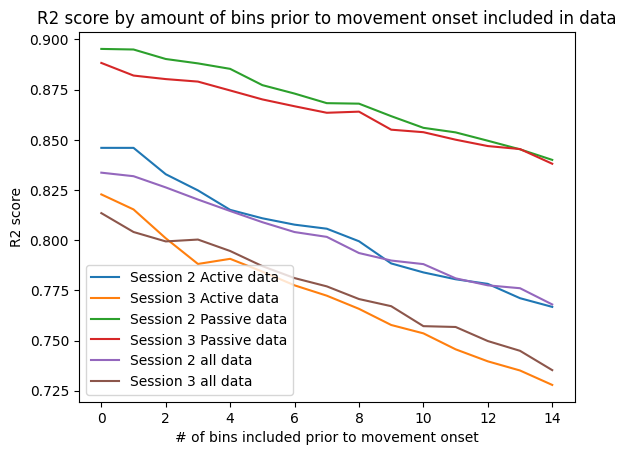

In [5]:
plt.plot([x[0] for x in prior_results[1]], label='Session 2 Active data')
plt.plot([x[1] for x in prior_results[1]], label='Session 3 Active data')
plt.plot([x[0] for x in prior_results[2]], label='Session 2 Passive data')
plt.plot([x[1] for x in prior_results[2]], label='Session 3 Passive data')

plt.plot([x[2] for x in prior_results[0]], label='Session 2 all data')
plt.plot([x[3] for x in prior_results[0]], label='Session 3 all data')
plt.legend()
plt.xlabel('# of bins included prior to movement onset')
plt.ylabel('R2 score')
plt.title("R2 score by amount of bins prior to movement onset included in data")
plt.plot()

### Seems obvious from data that inclusion of data prior to movement onset is detrimental to performance. Prior should be set to 0.

# Optimizing Ridge Regression hyperparameters

In [6]:
alphas = list(np.linspace(0, 10, 101))
ridge_results = []
for al in tqdm(alphas, ascii=' >='):
    model = Ridge(
        alpha=al,
        fit_intercept=True,
        )
    result = predict_2d(
            data_df = df,
            iterations=10,
            model=model,
            prior=0,
            post=15,
            col_to_use='PCA_window_from_full',
            col_to_predict='pos_window',
            cols_to_decode=[],
            time_offset=4,
            debug=False,
            sliding_window=0,
            return_coef=False
        )
    ridge_results.append([x[0] for x in result])

  0%|          | 0/101 [00:00<?, ?it/s]

# Results in changing the alpha are showing it's irrelevant.

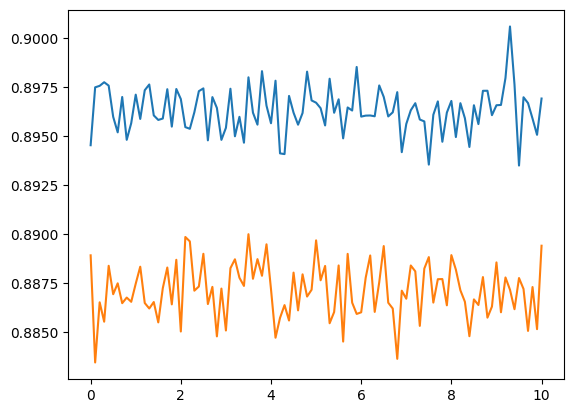

In [7]:
plt.plot(alphas, [i[0] for i in ridge_results], label='Session 2')
plt.plot(alphas, [i[1] for i in ridge_results], label='Session 3')


# Checking decoding on singular PC's

In [8]:
pc_results = []
window_size=15
start, end, amount = 15, 300, 150 
posts = np.linspace(start, end, amount).astype(int)
for df in tqdm([active_df, passive_df]):
    df_results = []
    for post in tqdm(posts):
        window_results = []
        for pc in range(30):
            result = predict_2d(
                data_df=df,
                iterations=10,
                model=Ridge(),
                prior=0,
                post=post,
                col_to_use='PCA_window_from_full', 
                col_to_predict='pos_window',
                cols_to_decode=[pc],
                time_offset=4,
                debug=False,
                sliding_window=15,
                return_coef=False
                )
            window_results.append([x[0] for x in result])
        df_results.append(window_results)
    pc_results.append(df_results)
#pc_result.shape = (2,50,30)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [9]:
x = np.array(pc_results)   

In [10]:
test_dict = {'trialtype':[],
             'session': [],
             'PC': [],
             'data':[]}
pc_df = pd.DataFrame(test_dict)
for k, df in enumerate(x):
    if k == 0:
        trialtype='Active'
    else:
        trialtype='Passive'
    for i in range(30):
        pc = i
        for session in [0, 1]:
            data = [j[i][session] for j in df]
            pc_df = pd.concat([pc_df, pd.DataFrame({'trialtype': trialtype, 'session': session+2, 'PC': pc,'data': [data]})])
pc_df['session'].astype(int).dtypes
pc_df['PC'].astype(int).dtypes
pc_df.head(5)

trialtype  session   PC                                               data
0    Active      2.0  0.0  [0.04681185473269571, 0.049617452261902215, 0....
0    Active      3.0  0.0  [0.05852281858334647, 0.06274410357180851, 0.0...
0    Active      2.0  1.0  [0.08994913004703635, 0.09155455562900174, 0.0...
0    Active      3.0  1.0  [0.28220548465880047, 0.2722908304162182, 0.26...
0    Active      2.0  2.0  [0.38223268068188826, 0.392610947025604, 0.403...

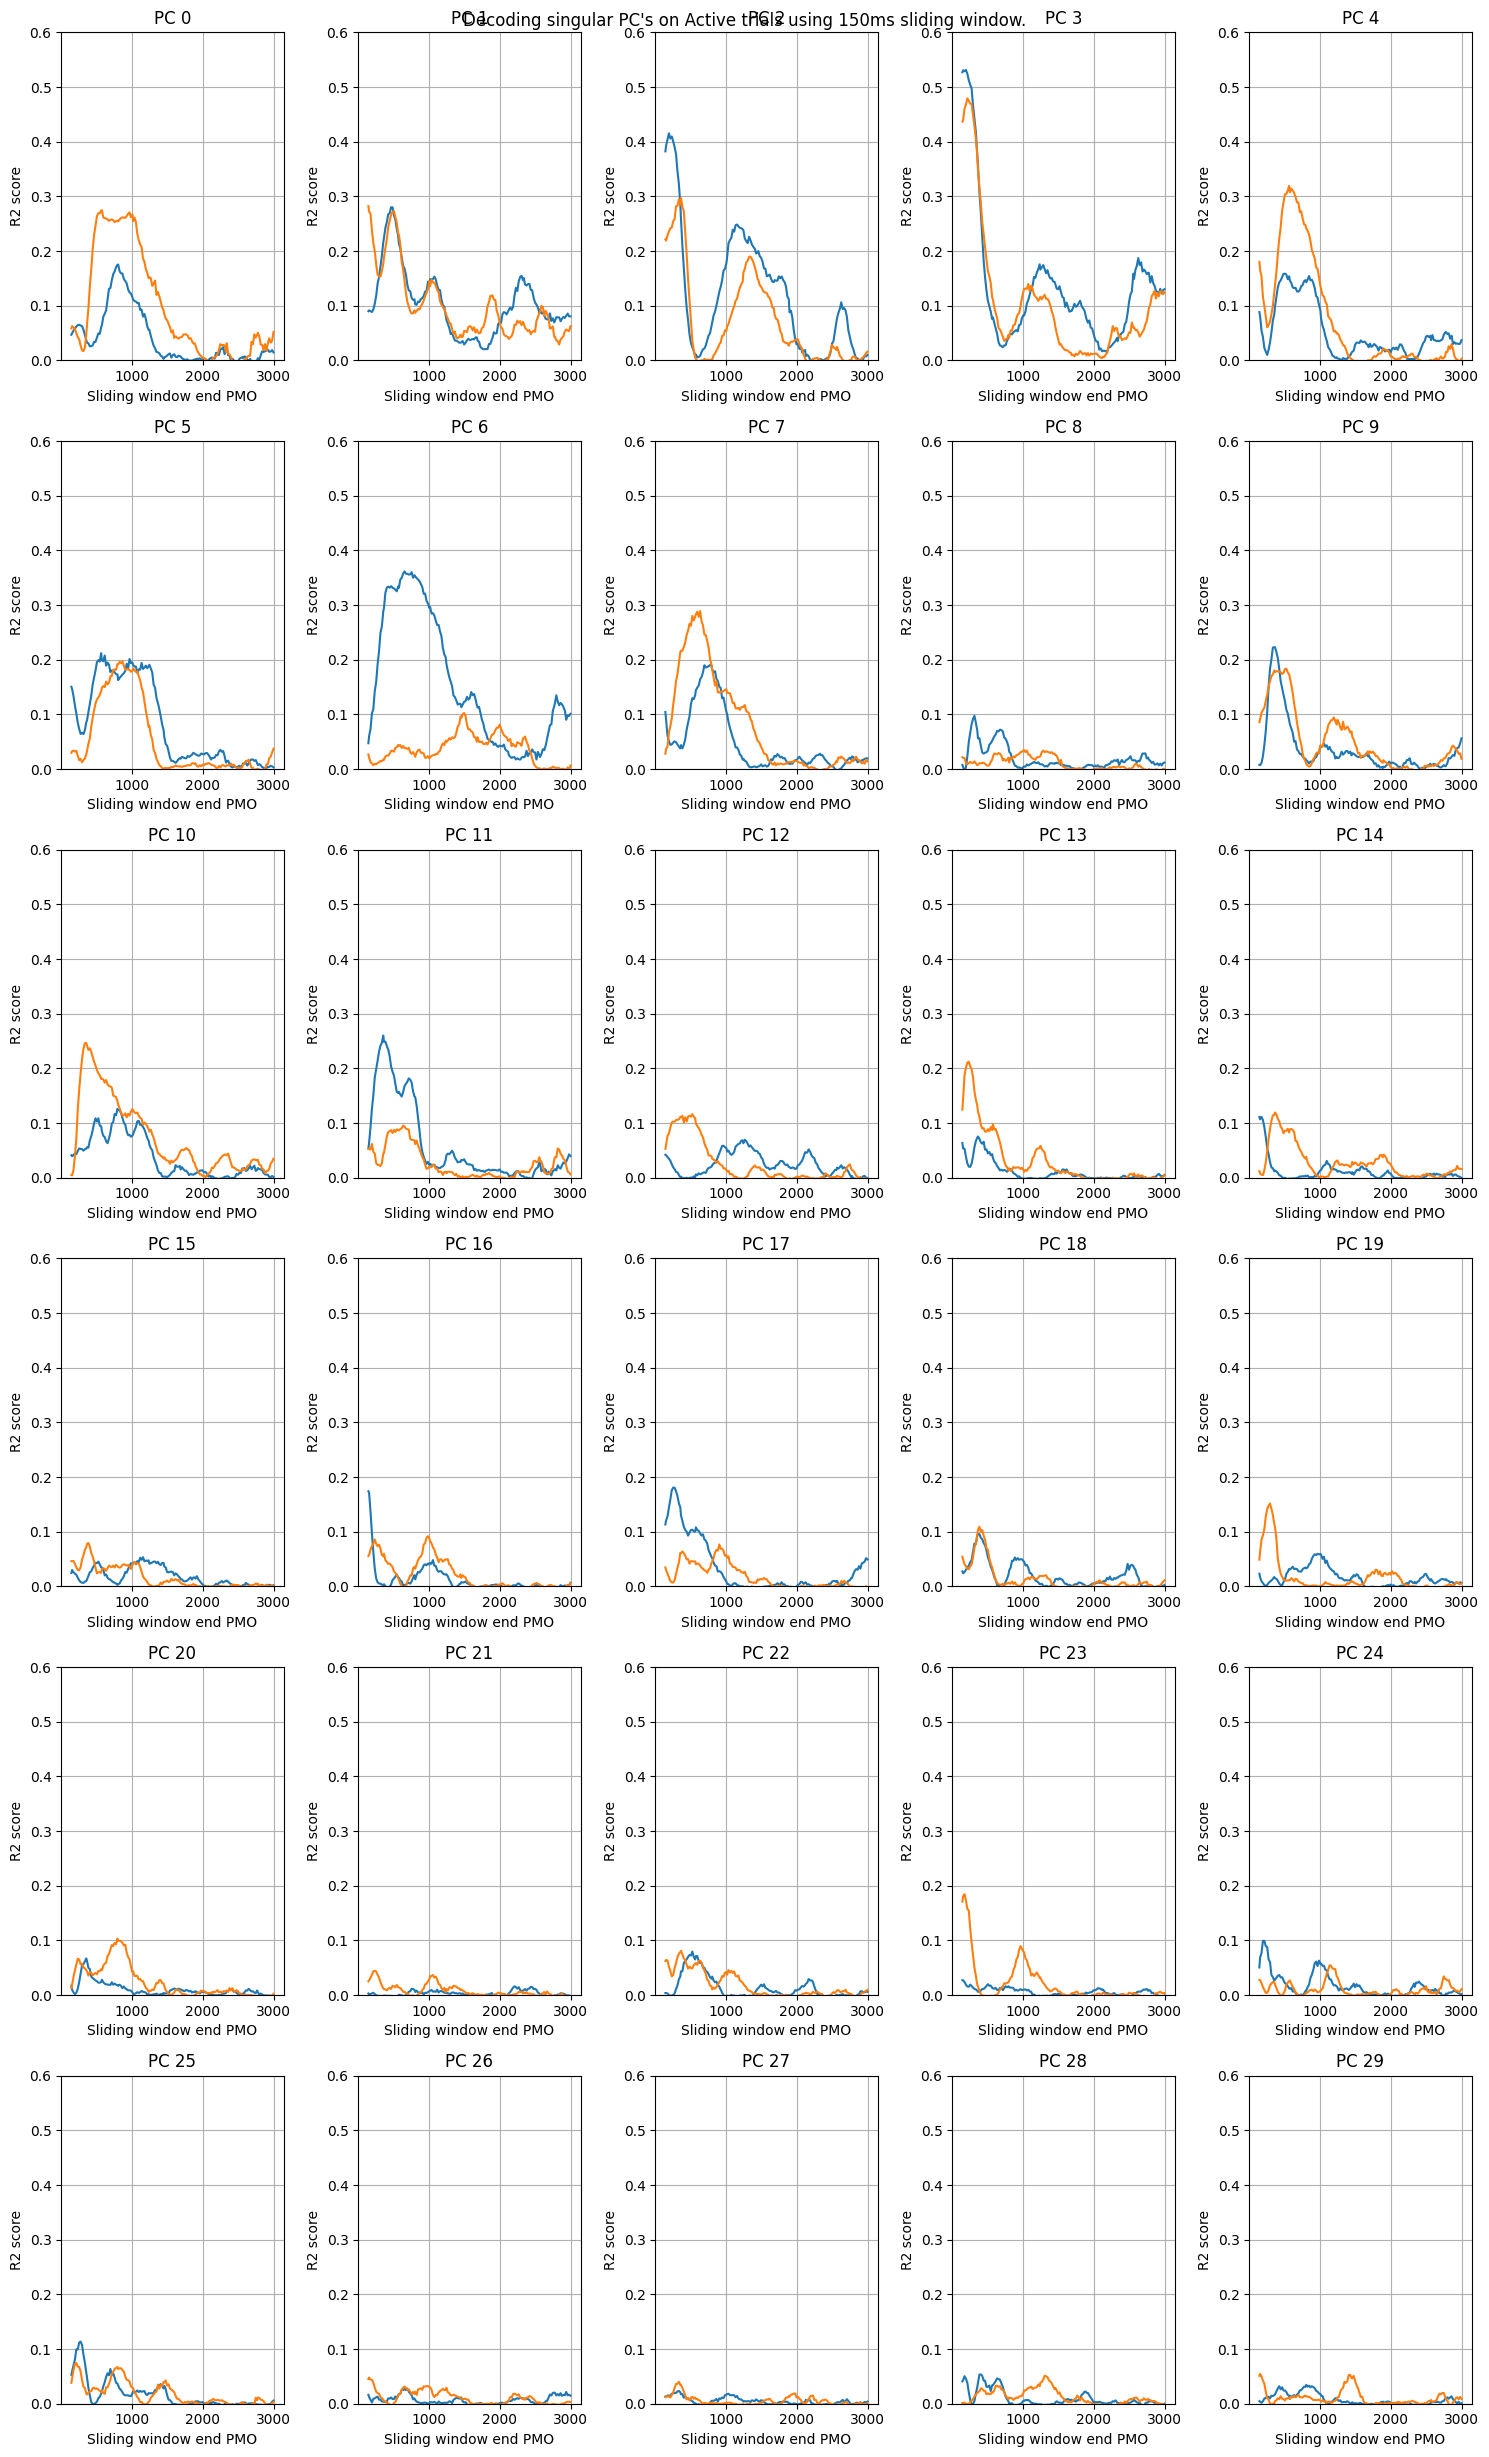

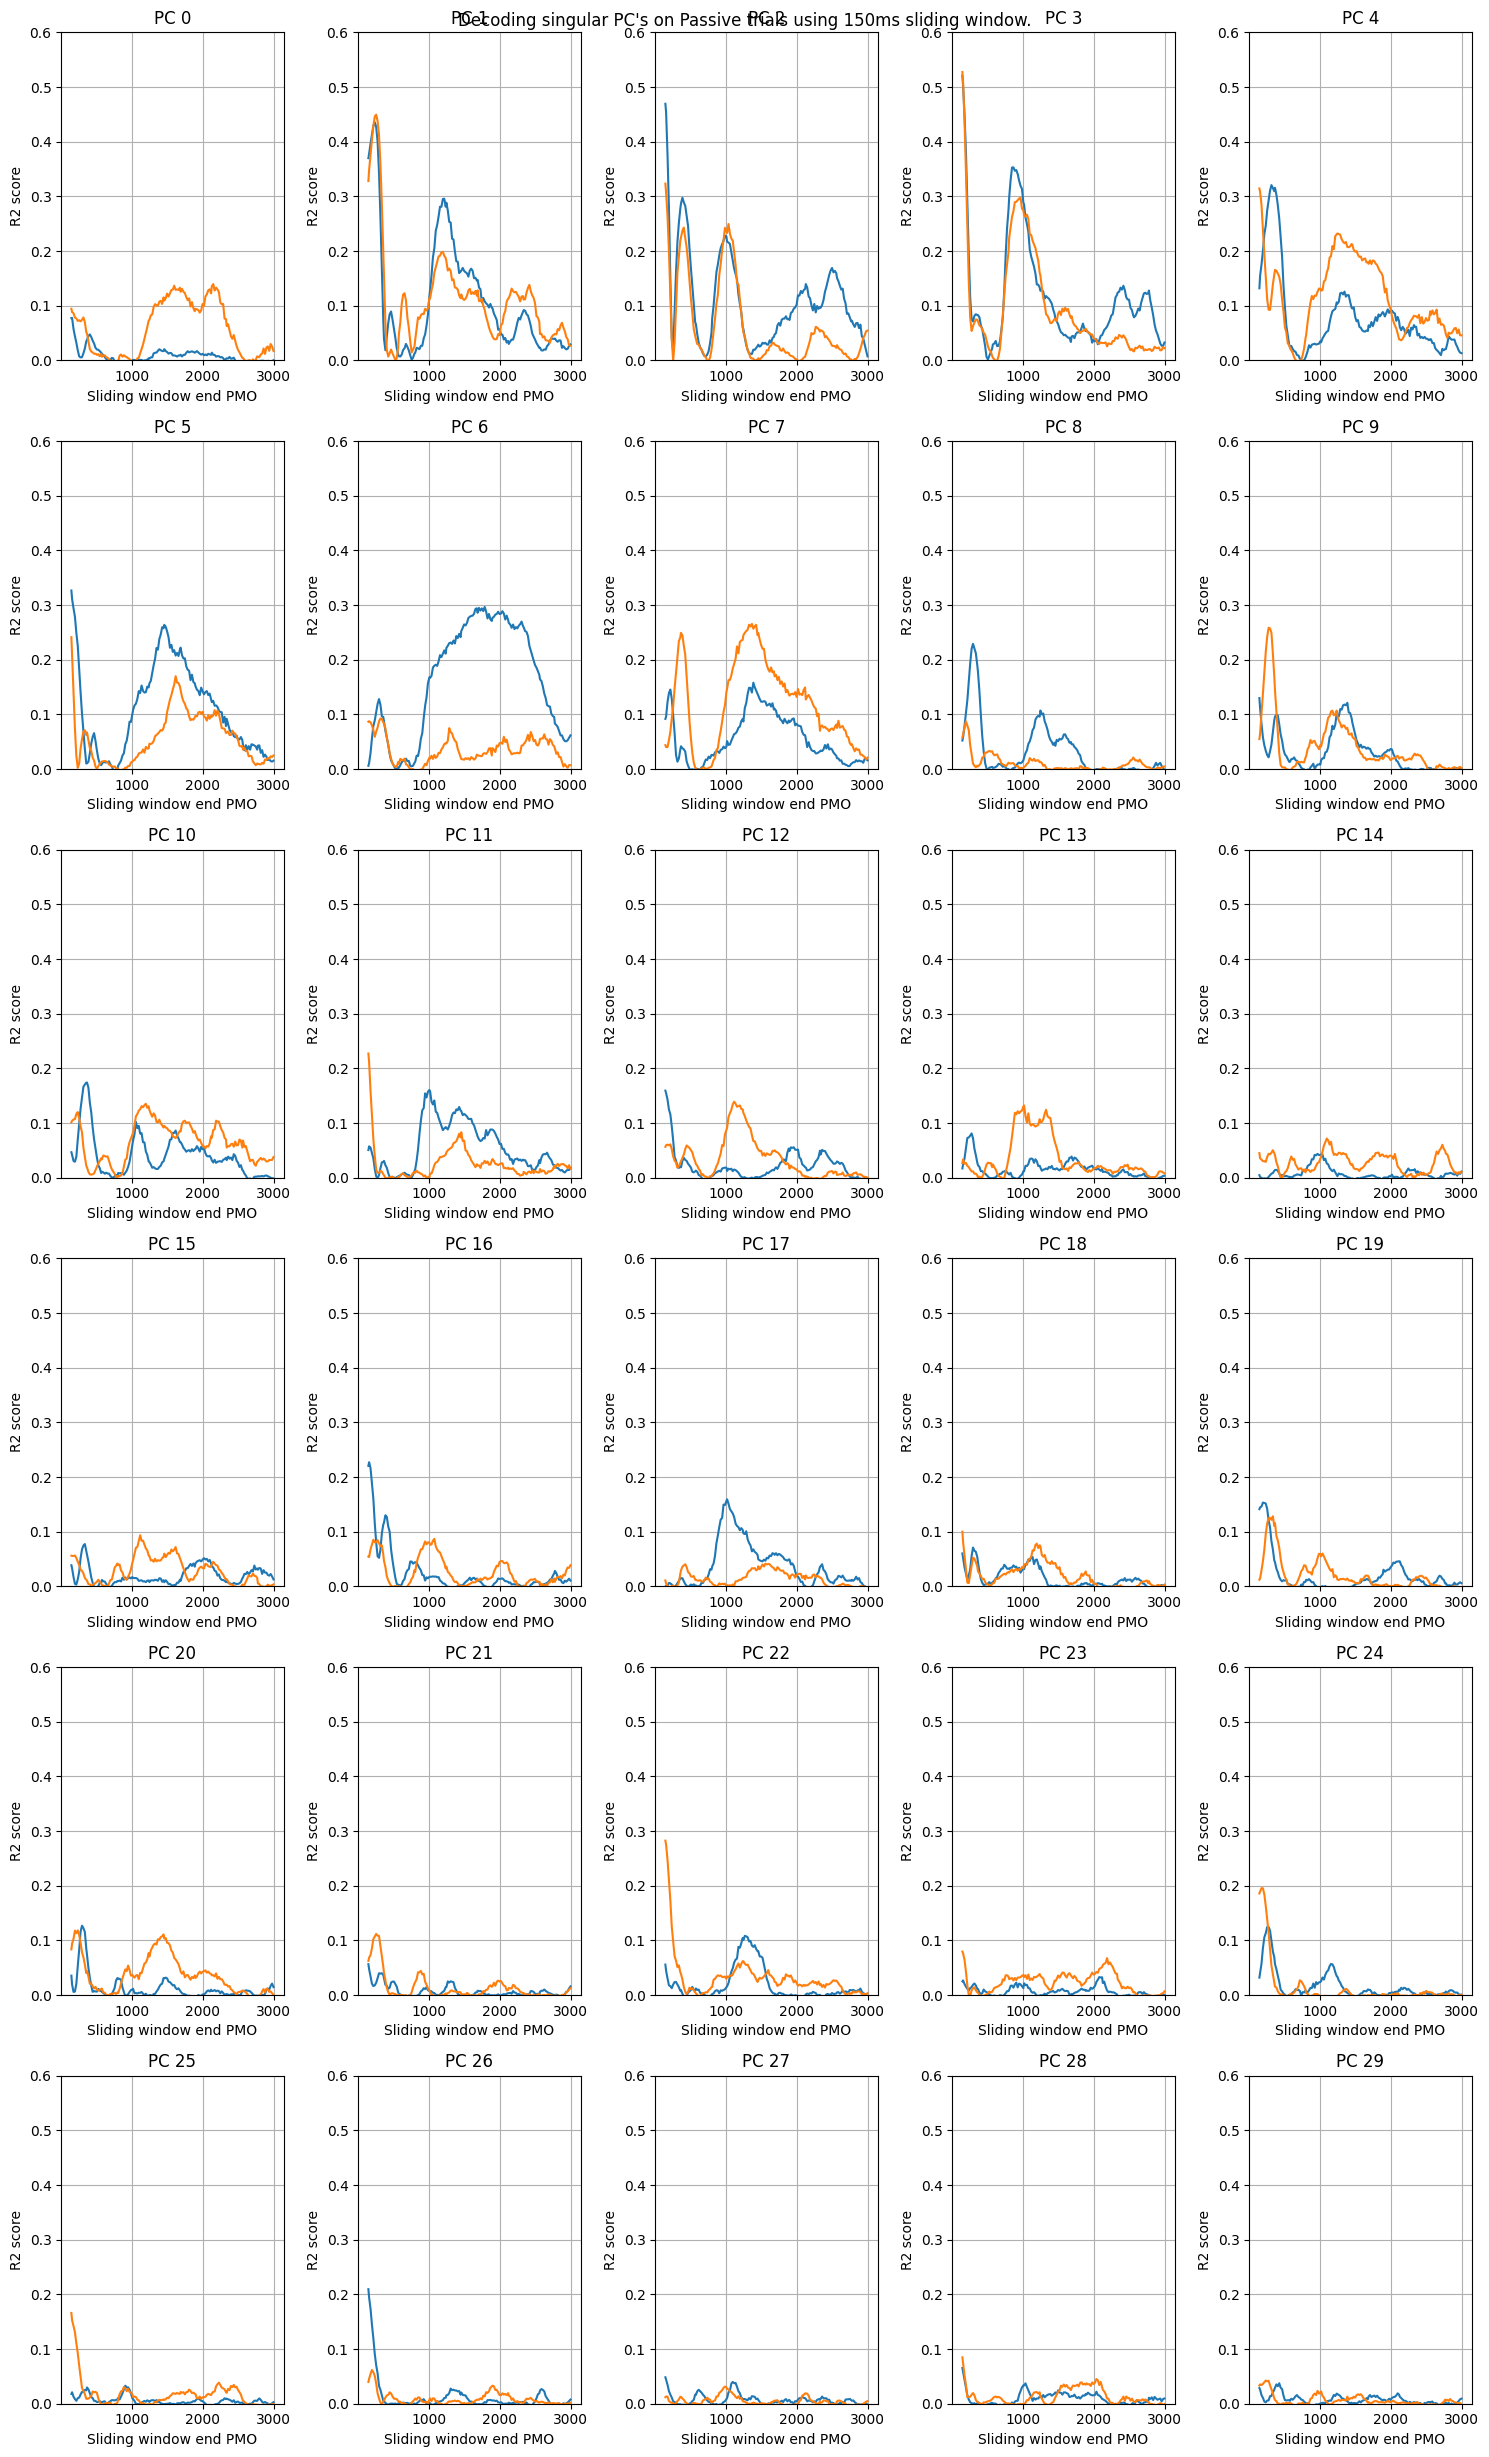

In [11]:
for k, df in enumerate(x):
    fig, axs = plt.subplots(6, 5, figsize=(15, 25))
    for i in range(0, 30):
        row = i // 5
        col = i % 5
        for session in [0,1]:
            value_list = [j[i][session] for j in df]
            axs[row, col].plot(posts*10, value_list, label=f"Session {session}")
            axs[row, col].set_title(f"PC {i}")
        axs[row, col].set_ylabel("R2 score")
        axs[row, col].set_xlabel("Sliding window end PMO")
        axs[row, col].grid()
        axs[row, col].set_ylim(0, 0.6)
    plt.suptitle(f"Decoding singular PC's on {'Active' if k==0 else 'Passive'} trials using 150ms sliding window.")
    plt.tight_layout()
    plt.show()

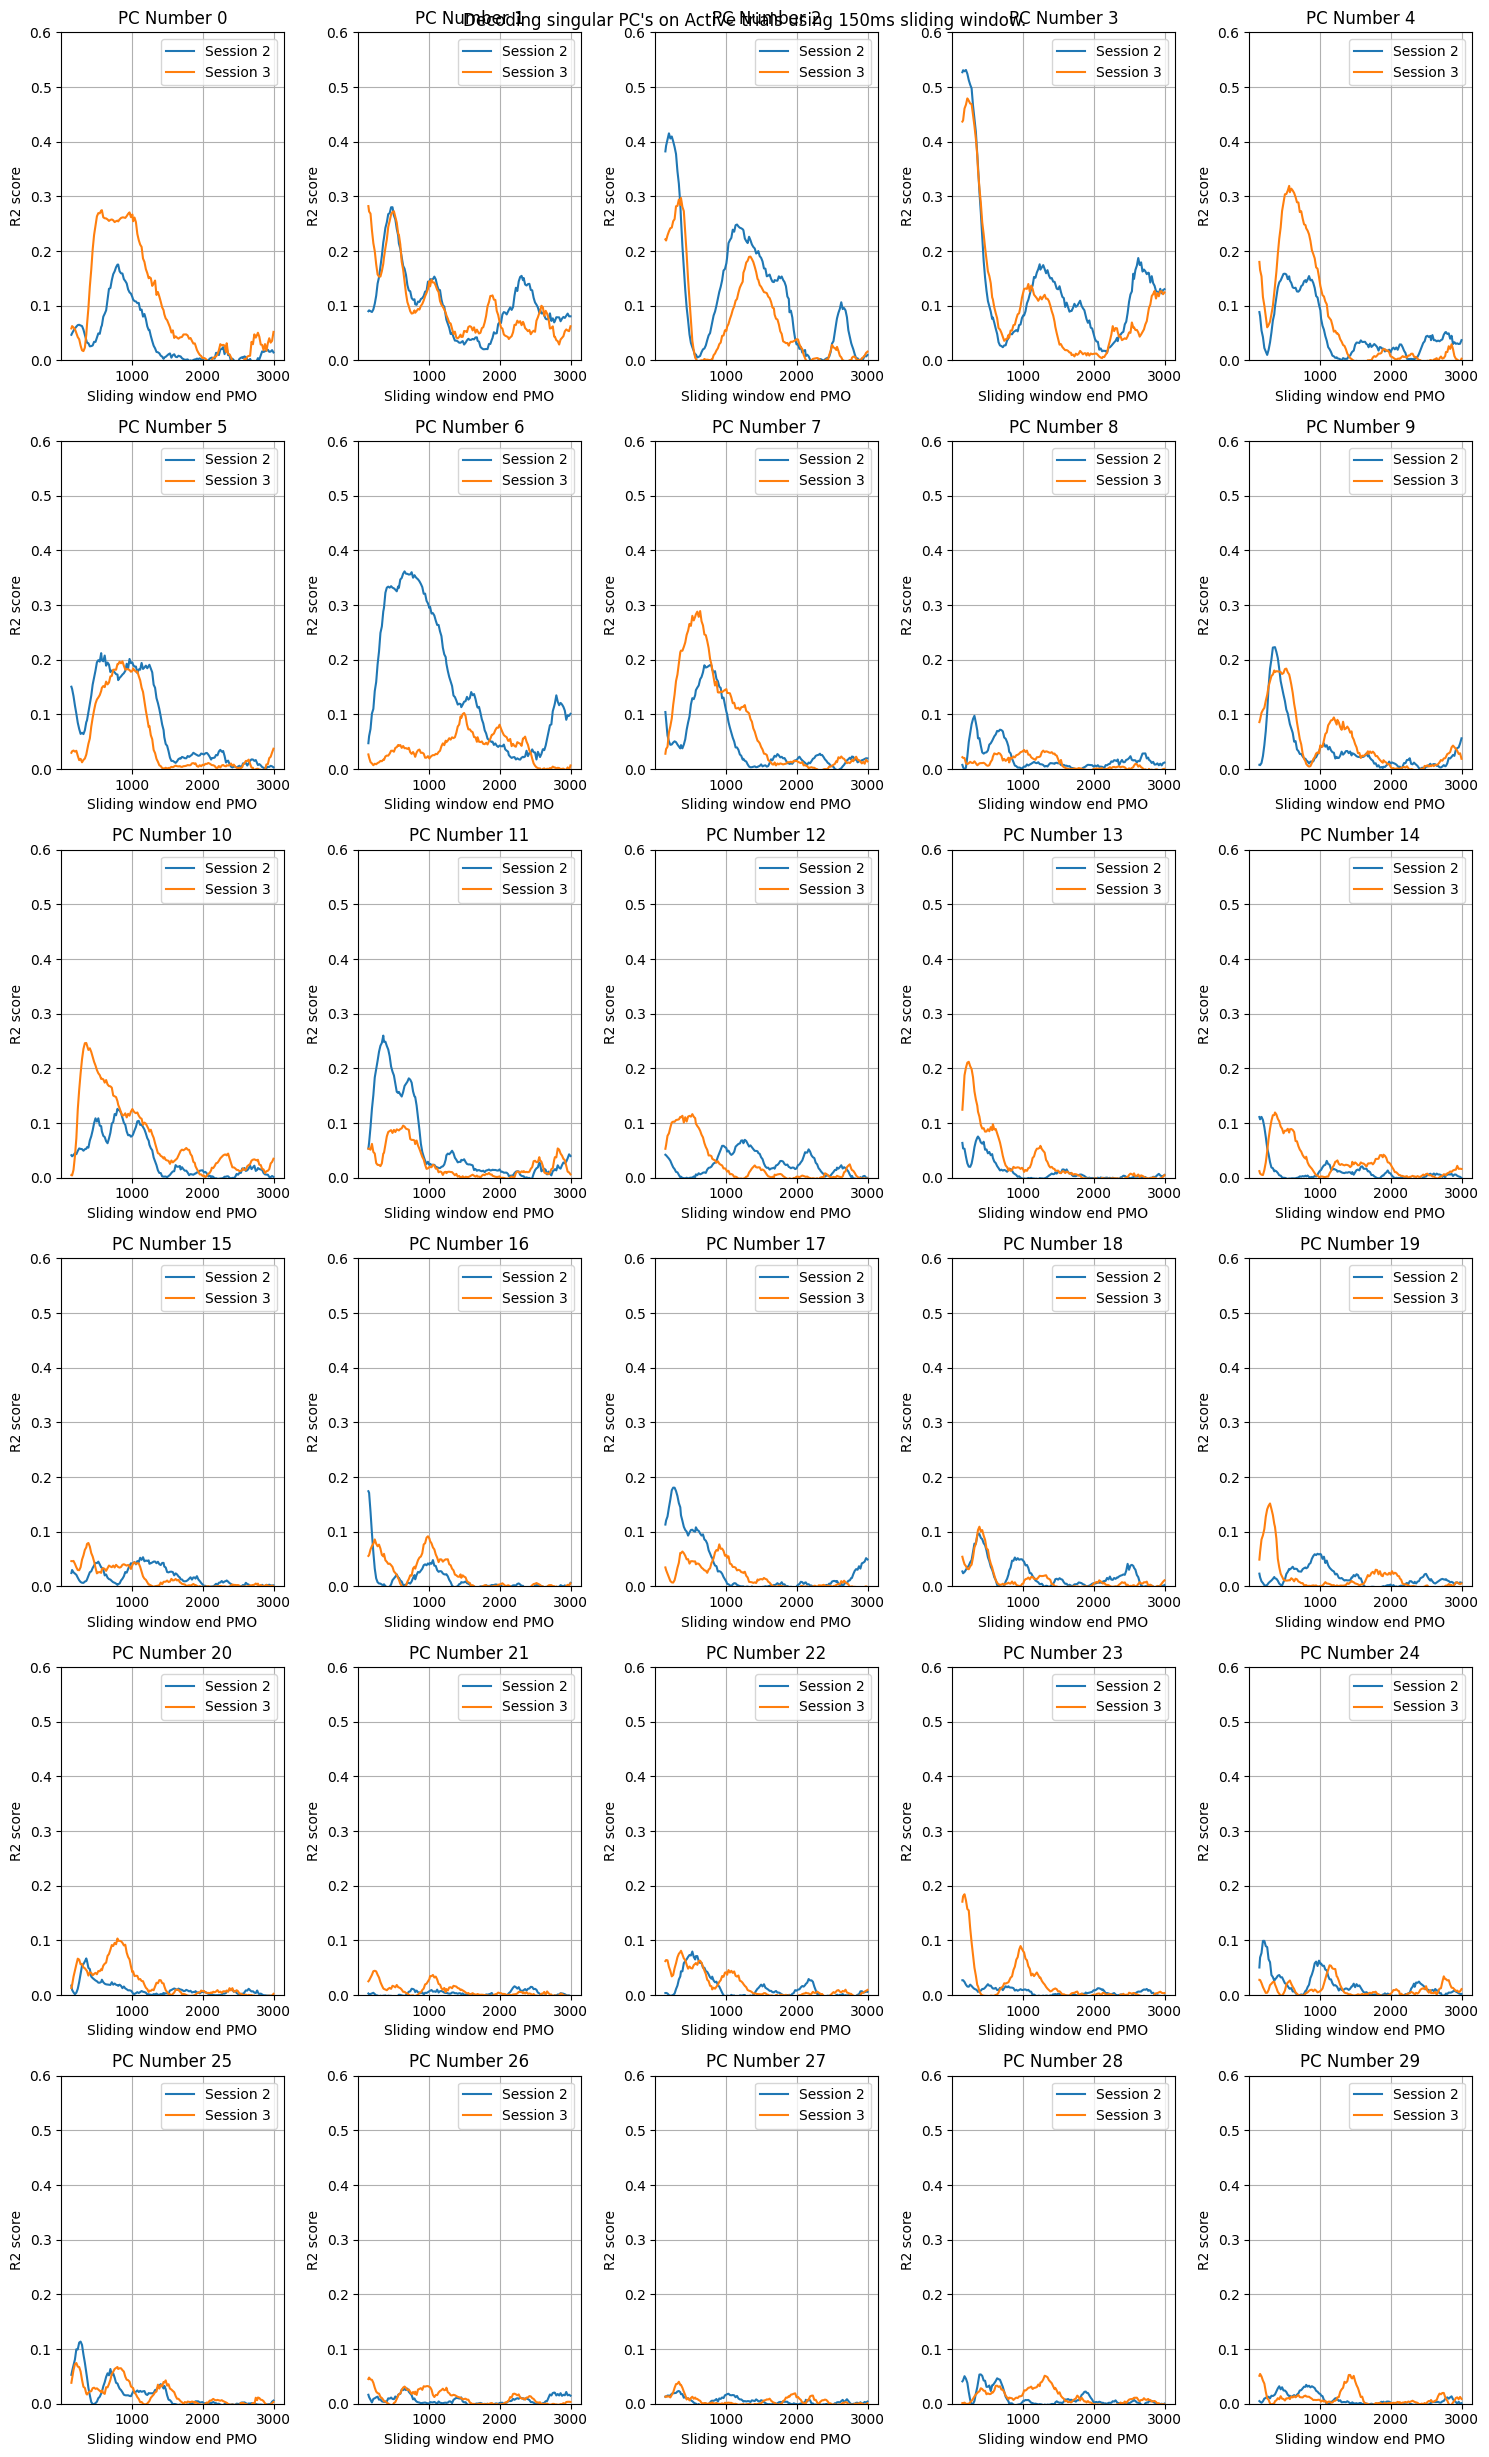

In [12]:
fig, axs = plt.subplots(6, 5, figsize=(15,25))
for pc in range(30):
    row, col = pc // 5, pc % 5
    for session in [0, 1]:
        trial = pc_df[(pc_df['session'] == session +2) & (pc_df.PC == pc) & (pc_df.trialtype=='Active')]
        axs[row, col].plot(posts*10, trial['data'][0], label=f'Session {session+2}')
    axs[row, col].set_title(f'PC Number {pc}')
    axs[row, col].set_ylabel("R2 score")
    axs[row, col].set_xlabel("Sliding window end PMO")
    axs[row, col].grid()
    axs[row, col].set_ylim(0, 0.6)
    axs[row, col].legend()
plt.suptitle(f"Decoding singular PC's on Active trials using 150ms sliding window.")
plt.tight_layout()
plt.show()



# Notes on Active trials per PC:

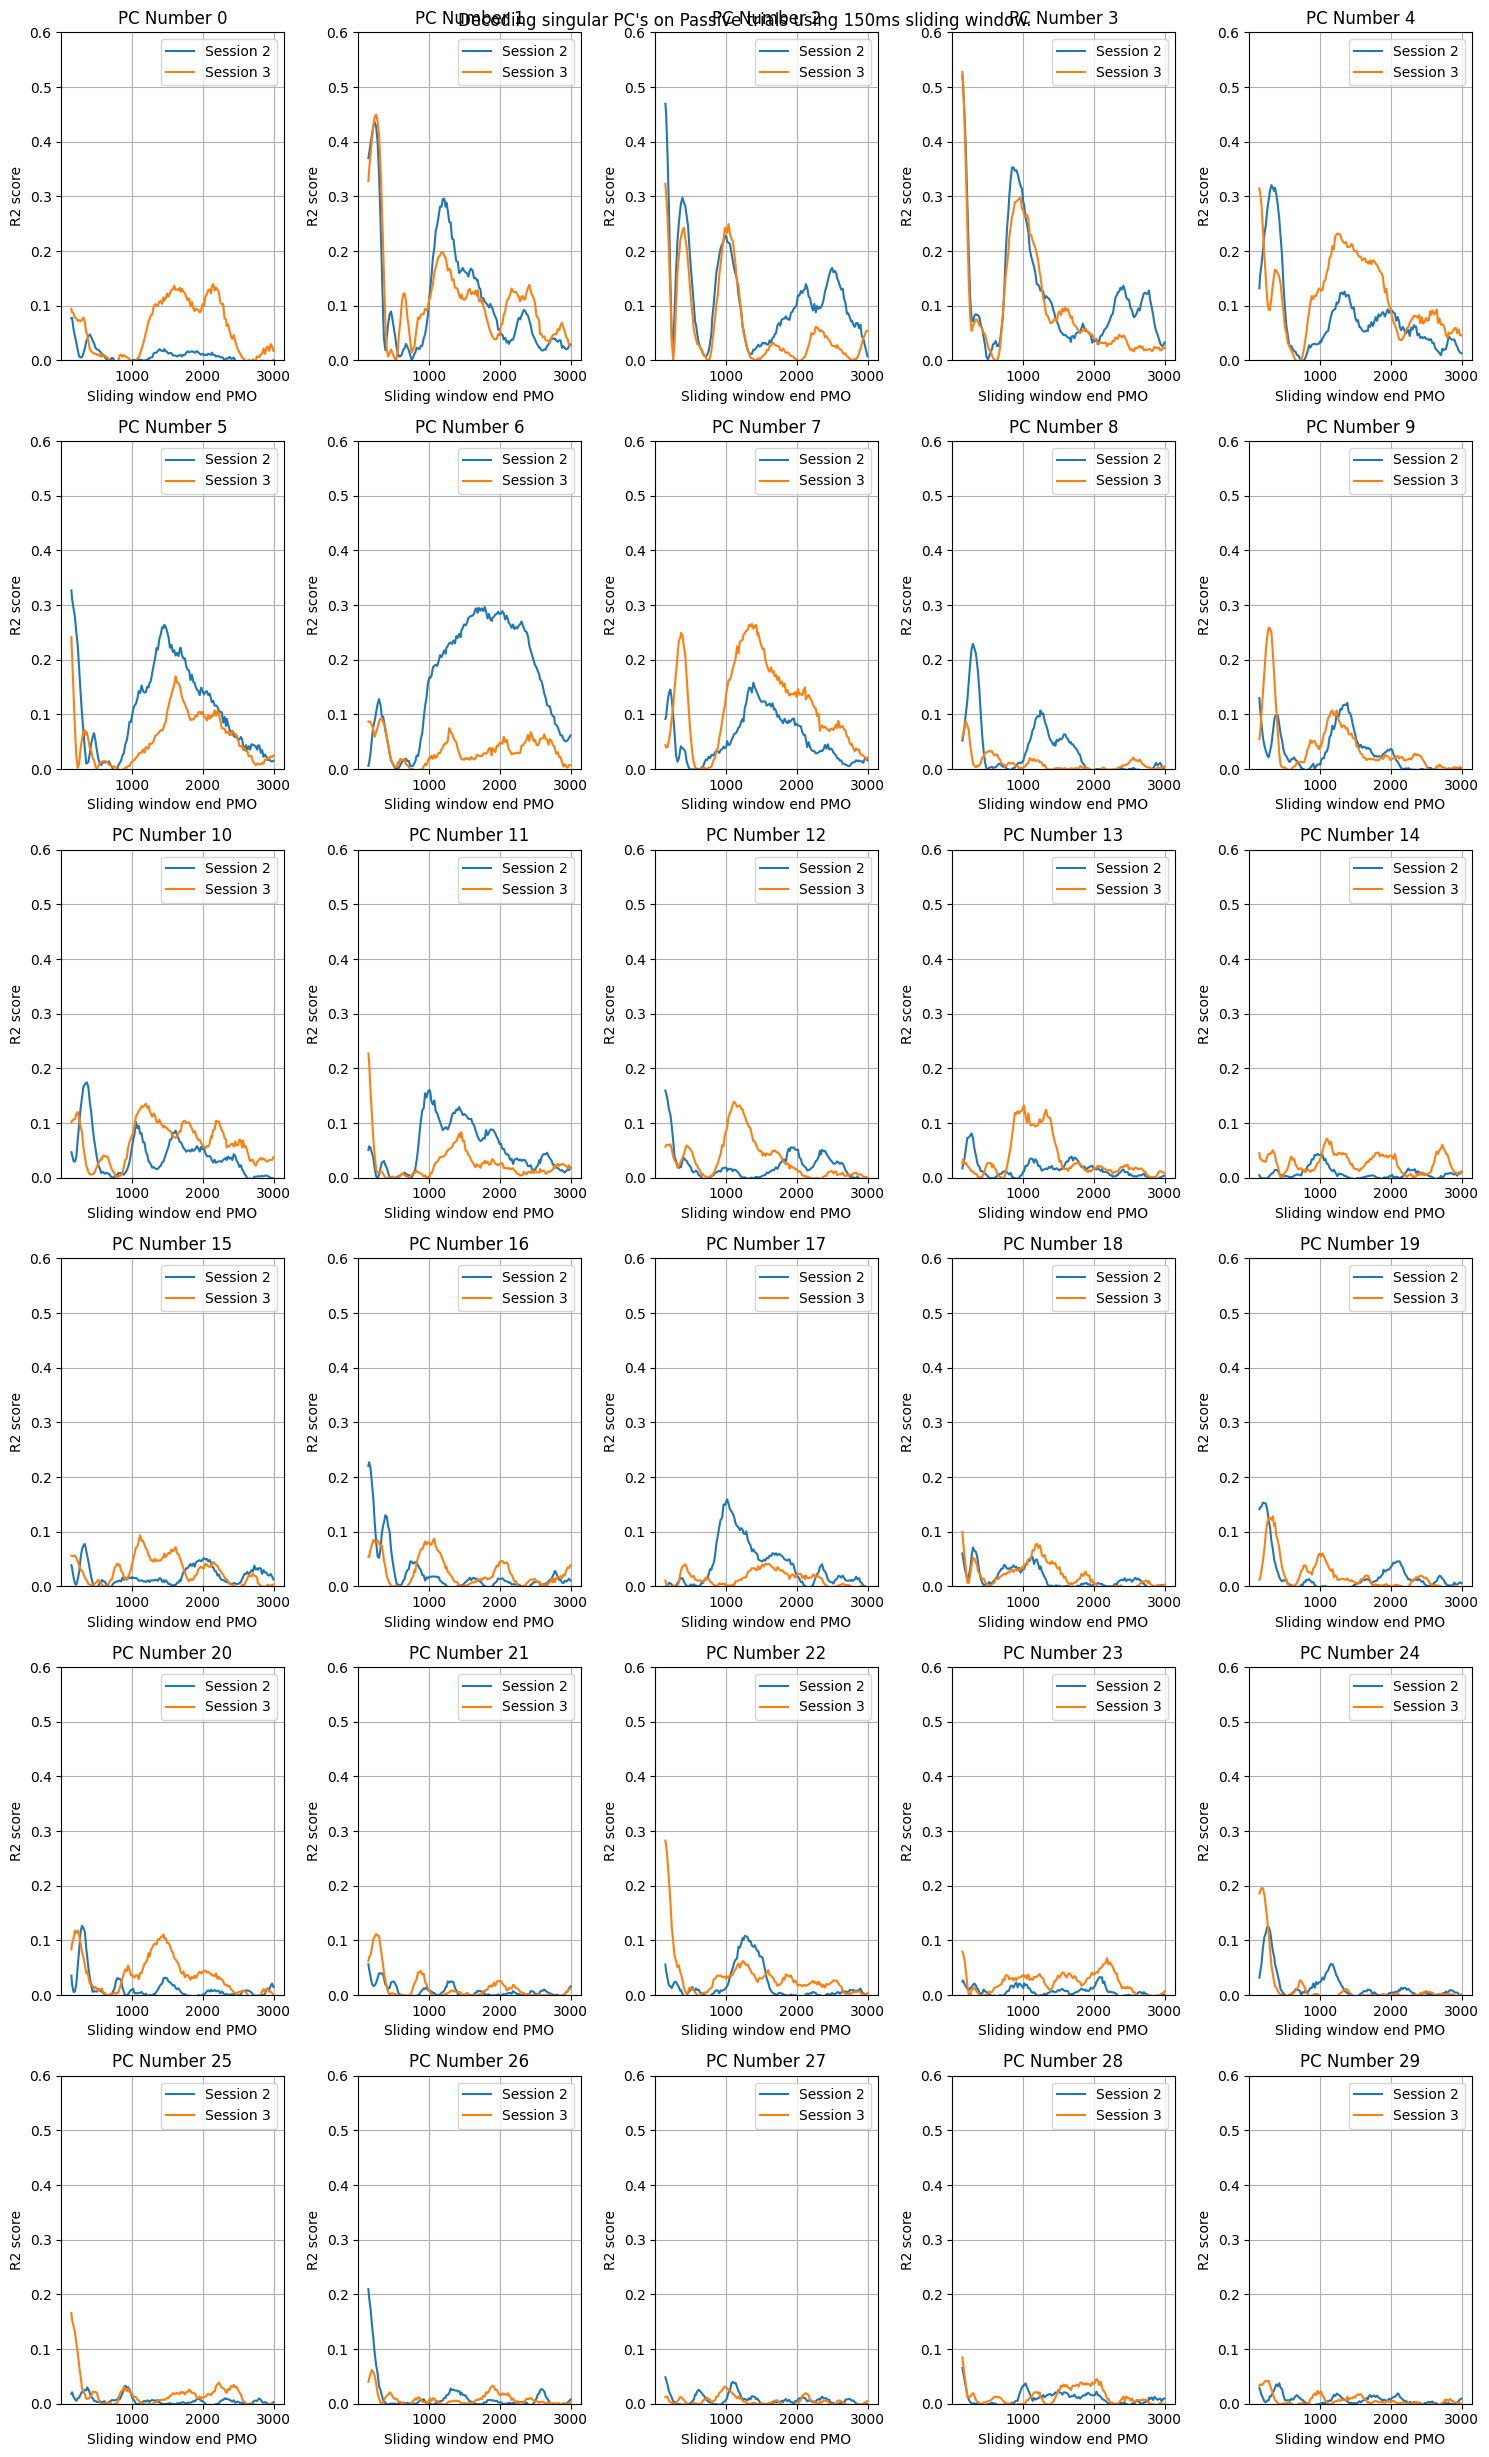

In [13]:
fig, axs = plt.subplots(6, 5, figsize=(15,25))
for pc in range(30):
    row, col = pc // 5, pc % 5
    for session in [0, 1]:
        trial = pc_df[(pc_df['session'] == session +2) & (pc_df.PC == pc) & (pc_df.trialtype=='Passive')]
        axs[row, col].plot(posts*10, trial['data'][0], label=f'Session {session+2}')
    axs[row, col].set_title(f'PC Number {pc}')
    axs[row, col].set_ylabel("R2 score")
    axs[row, col].set_xlabel("Sliding window end PMO")
    axs[row, col].grid()
    axs[row, col].set_ylim(0, 0.6)
    axs[row, col].legend()
plt.suptitle(f"Decoding singular PC's on Passive trials using 150ms sliding window.")
plt.tight_layout()
plt.show()



# Notes on the passive trials per PC:

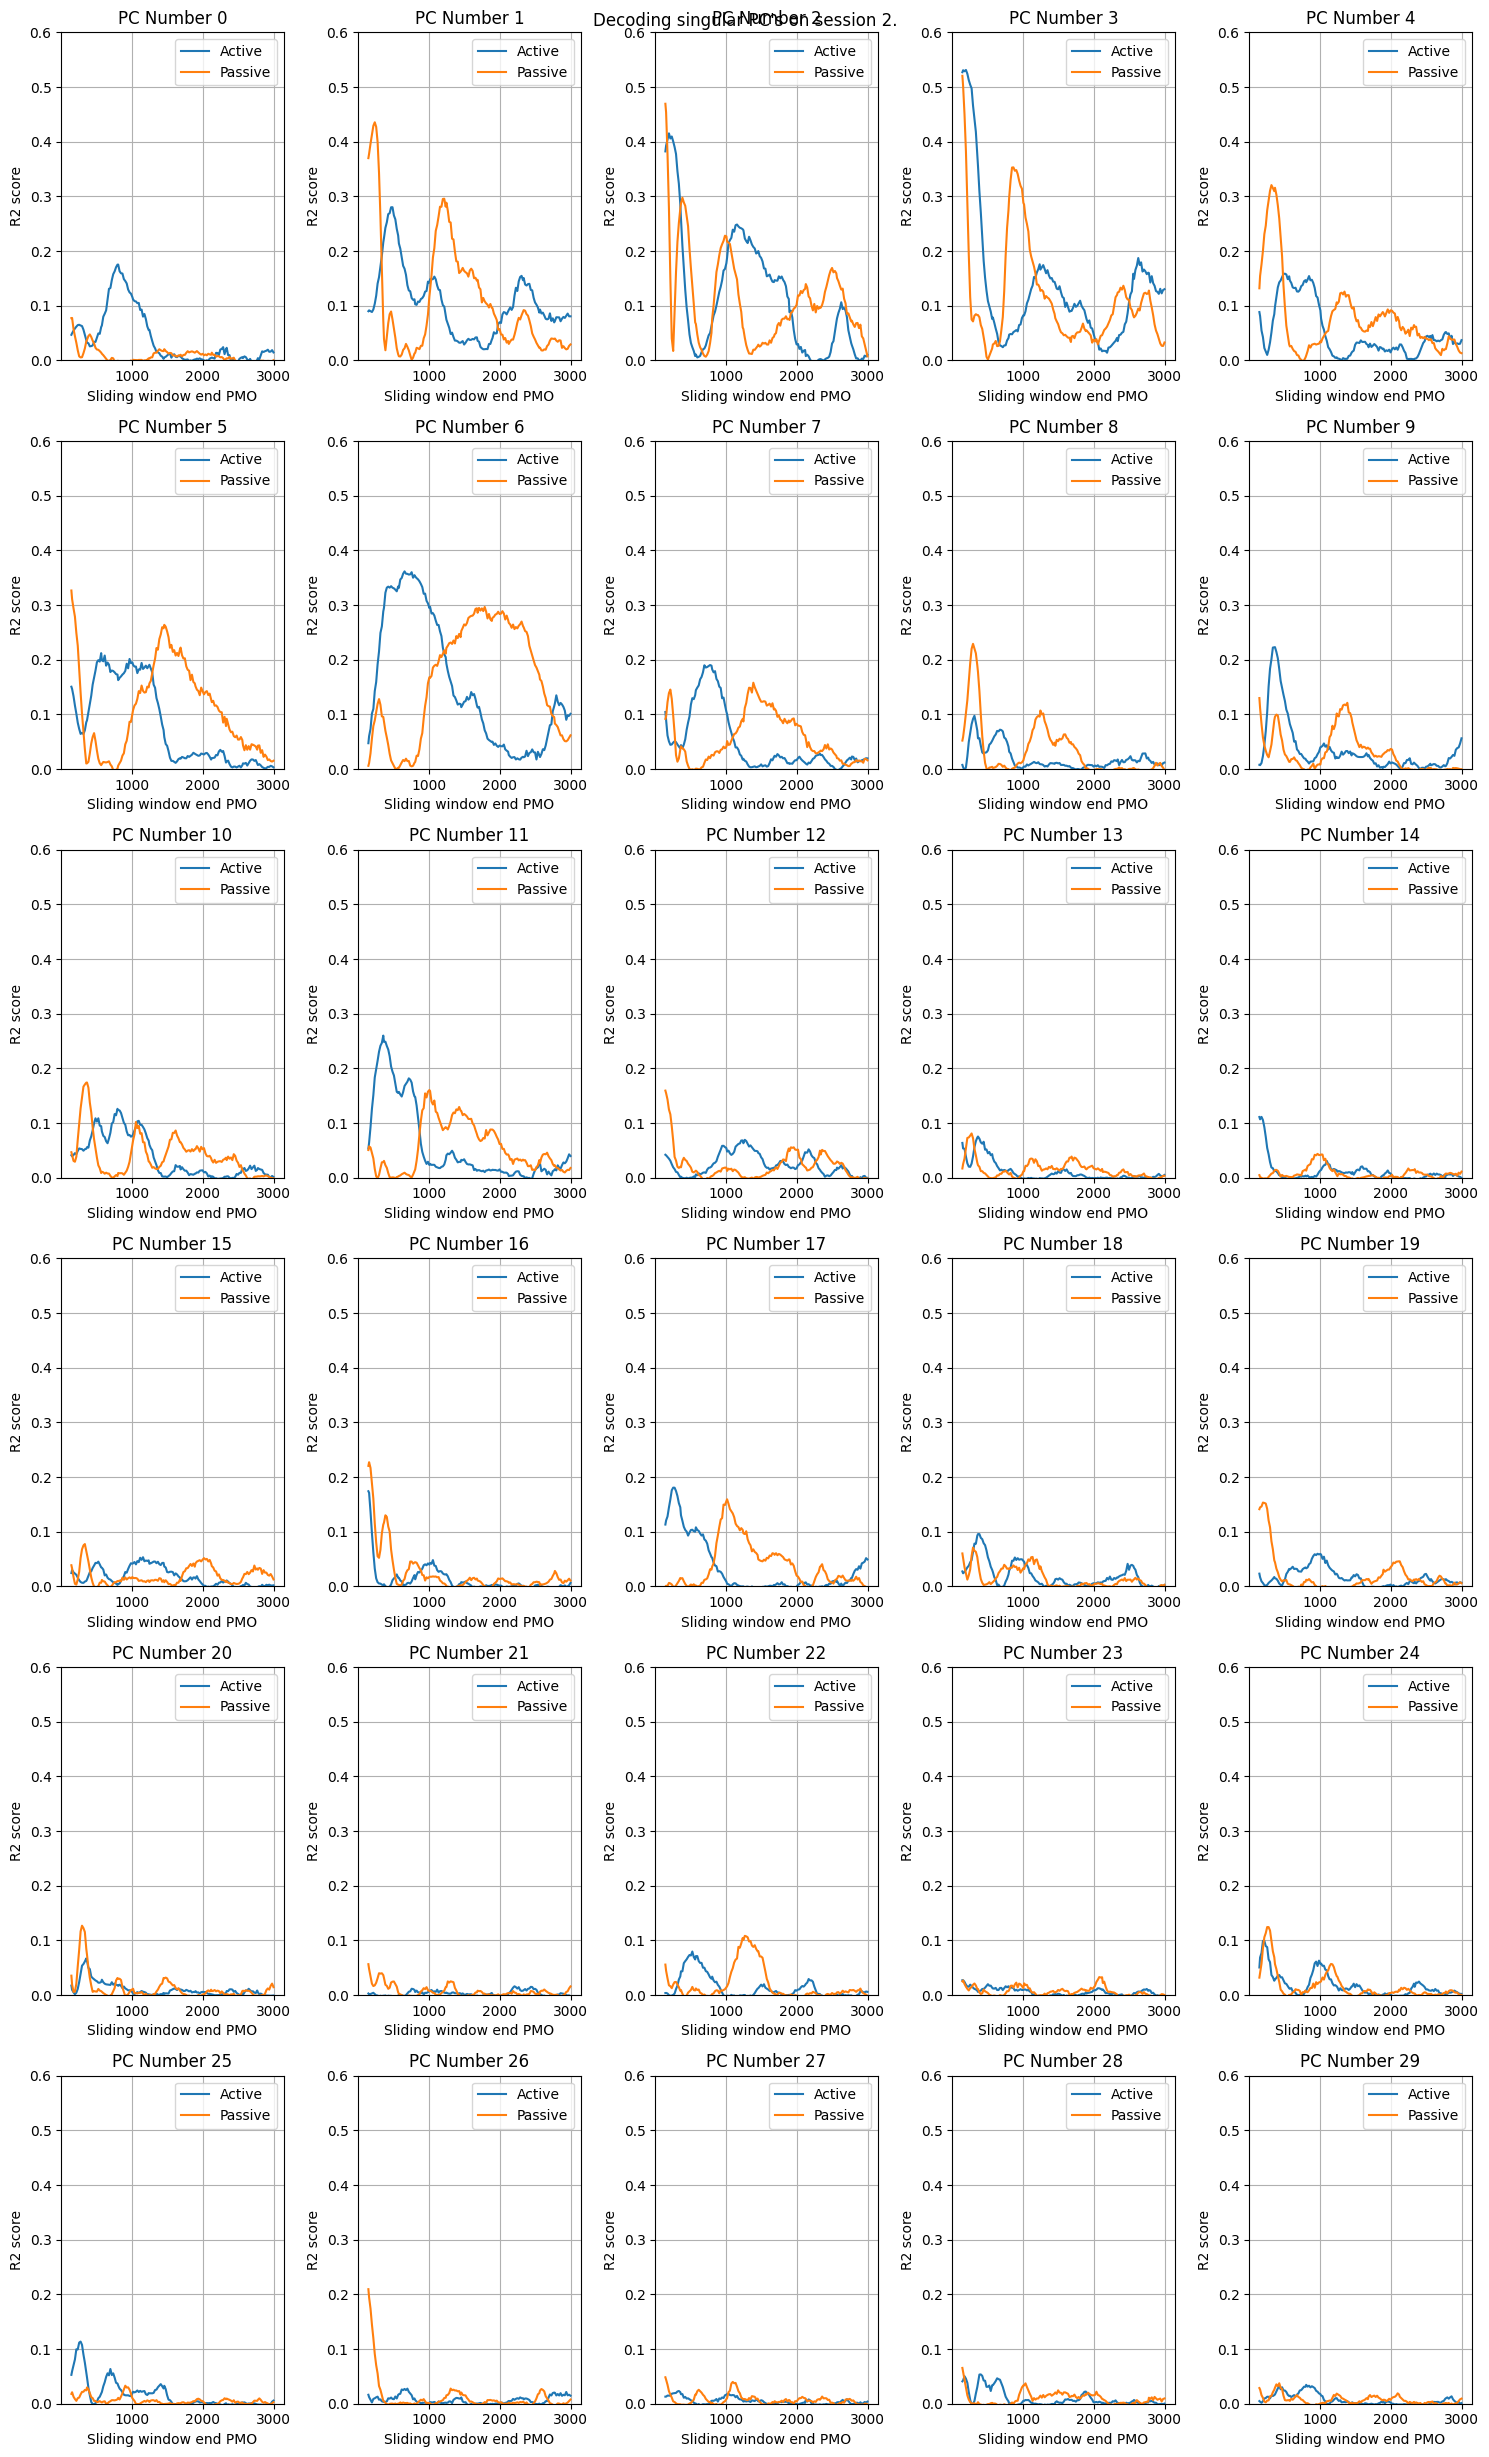

In [14]:
fig, axs = plt.subplots(6, 5, figsize=(15,25))
for pc in range(30):
    row, col = pc // 5, pc % 5
    for trialtype in ['Active', 'Passive']:
        trial = pc_df[(pc_df['session'] == 2) & (pc_df.PC == pc) & (pc_df.trialtype==trialtype)]
        axs[row, col].plot([posts*10][0], trial['data'][0], label=trialtype)
    axs[row, col].set_title(f'PC Number {pc}')
    axs[row, col].set_ylabel("R2 score")
    axs[row, col].set_xlabel("Sliding window end PMO")
    axs[row, col].grid()
    axs[row, col].set_ylim(0, 0.6)
    axs[row, col].legend()
plt.suptitle(f"Decoding singular PC's on session 2.")
plt.tight_layout()
plt.show()



# Notes:

- PC1 has a great division in decoding difference when decoding on the first 150ms
- PC4 has an interesting bump during passive trials and drop during active trials around 200ms.

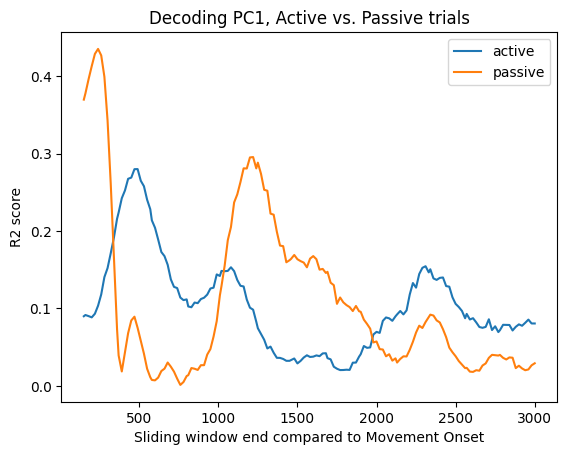

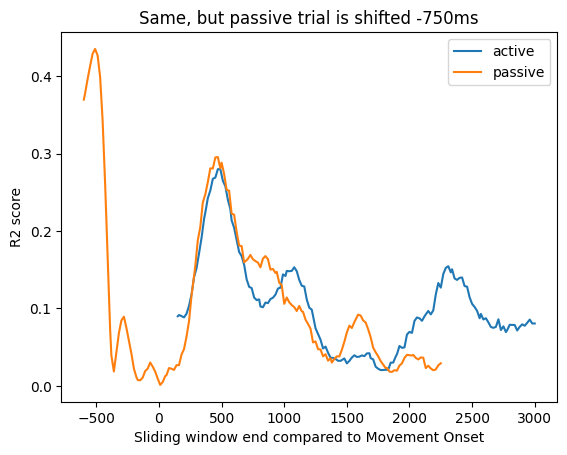

In [15]:
act_pc1= pc_df[(pc_df['session'] == 2) & (pc_df['trialtype']=='Active') & (pc_df.PC==1)]
pas_pc1 =pc_df[(pc_df['session'] == 2) & (pc_df['trialtype']=='Passive') & (pc_df.PC==1)]
plt.plot(posts * 10, act_pc1.data[0], label='active')
plt.plot(posts * 10, pas_pc1.data[0], label='passive')
plt.legend()
plt.xlabel("Sliding window end compared to Movement Onset")
plt.ylabel("R2 score")
plt.title("Decoding PC1, Active vs. Passive trials")
plt.show()


plt.plot(posts * 10, act_pc1.data[0], label='active')
plt.plot(posts * 10-750, pas_pc1.data[0], label='passive')
plt.legend()
plt.xlabel("Sliding window end compared to Movement Onset")
plt.ylabel("R2 score")
plt.title("Same, but passive trial is shifted -750ms")
plt.show()

This PC looks very similar when you shift the passive trials by ~750ms, which is the average time between the MO caused by bump and cue time + reaction time. This hints at this PC being involved with the input-null dimension. Reason for thinking this is that the decoding accuracy goes to 0.05 when movement is non-intended. However, quickly after the movement onset has been detected, the monkey will account for the passive movement and go back to the starting position, resulting in hardly any movement and therefore decoding difficulty.

The excellent decoding activity when decoding 0-150ms for passive trials can be said to be caused by the high movement activity during the passive bump. In that case, this PC turns out only to be informative during high movement, and there's no input-null dimension involved.

# Write a function to compare active&passive quickly:

In [16]:
def compare_actpas(data_df, pc, session, shift:int = 0):
    df = data_df
    act_pc1= pc_df[(df['session'] == 2) & (df['trialtype']=='Active') & (df.PC==pc)]
    pas_pc1 =pc_df[(df['session'] == session) & (df['trialtype']=='Passive') & (df.PC==pc)]
    plt.plot(posts * 10, act_pc1.data[0], label='active')
    plt.plot(posts * 10-shift, pas_pc1.data[0], label='passive')
    plt.legend()
    plt.xlabel("Sliding window end compared to Movement Onset")
    plt.ylabel("R2 score")
    plt.grid()
    plt.xticks(range(150, 3001, 200))
    plt.title(f"Decoding PC {pc}, Active vs. Passive trials")
    plt.show()


# Check all PC's 

In [17]:
#"Hiding this so it won't have to be repeatedly printed"
# for x in range(30):
#     compare_actpas(pc_df, 
#                pc=x, 
#                session=2
#                )
#compare_actpas(pc_df, pc=2, session=2, shift=750)

# Interesting PC's for session 2:
- 1
    - As seen above. Shifted, they line up.
- 4
    - Not very comparable when shifted. However, big difference between decoding 100-250 to 350-500
- 6
    - Similar to PC1. Similar curves when shifted.
- 7
    - Similar curves when shifted, mostly during resting period? ~windows from 350-500ms to 850-1000ms.
- 9
    - Relatively similar curves when shifted in window 150-300ms to 450-600ms.
- 11
    - When shifted, the accuracy for active trials is much higher during active movement. Decoding during passive movement is very low, seemingly showing that intention is correlated with this PC.
#### Note that starting from here, accuracies in general are quite low, but I'd still like to show the relative decoding difference between active and passive, so I'm (mostly) i
- 12
    - Relatively high decoding for passive trials 0-150 to 
- 14
- 17
- 19
- 21 
- 22
- 24
- 24
- 25 
- 26

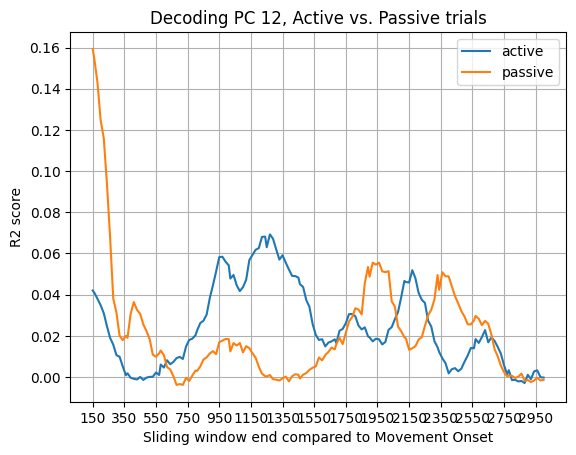

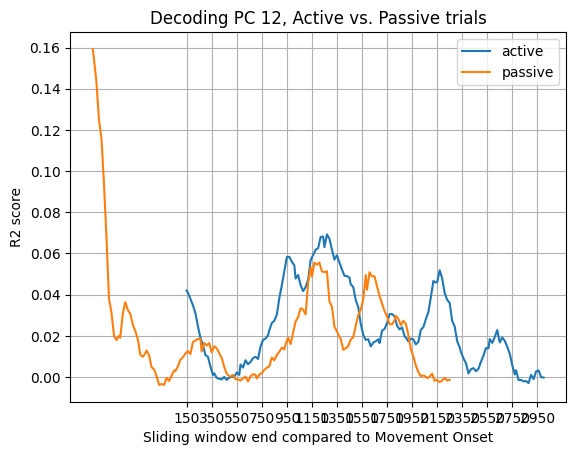

In [18]:
compare_actpas(pc_df, pc=12, session=2)
compare_actpas(pc_df, pc=12, session=2, shift=750)

In [19]:
print(len(pc_df['data'].iloc[0]))

150


# Tuesday

The pc_df contains decoding efficiency on that specific PC during some window. I'm not necessarily interested in the PC anymore. Now, I'd like to find the direction the PC over some specific trial vs. the direction of another PC.

- Write a function that compares PC's for specific trials.

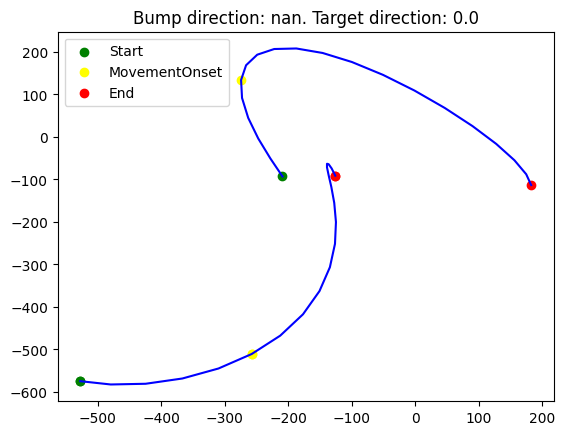

Now showing PC's from MO-prior to MO+post:


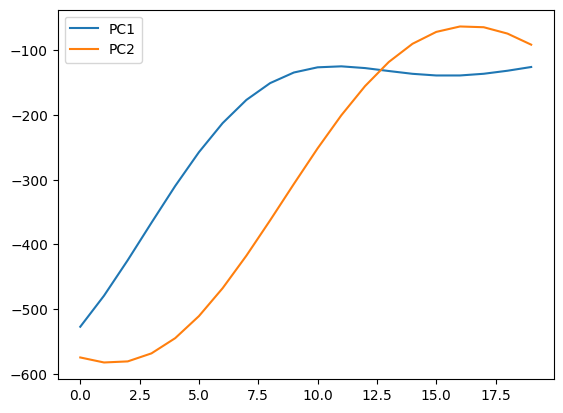

Now showing the averages:


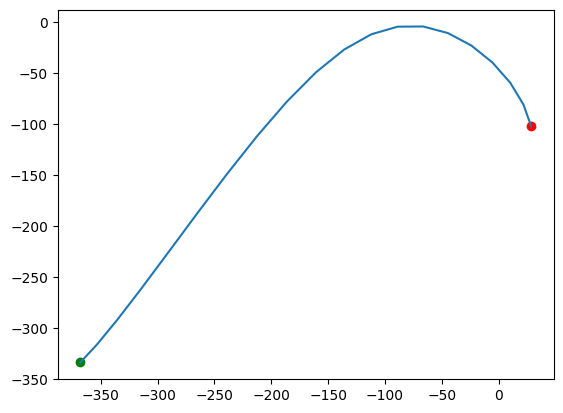

[[array([-208.79054  , -227.89026  , -246.94977  , -262.75732  ,
         -272.47287  , -273.98938  , -266.11014  , -248.55028  ,
         -221.81125  , -186.99632  , -145.62247  ,  -99.48505  ,
          -50.57901  ,   -1.0681225,   46.73647  ,   90.4352   ,
          127.6754   ,  156.37007  ,  174.97548  ,  182.77115  ],
        dtype=float32),
  array([-527.1745  , -479.18854 , -424.27115 , -366.4081  , -309.57056 ,
         -257.29202 , -212.33817 , -176.50635 , -150.53761 , -134.14174 ,
         -126.12512 , -124.603645, -127.29324 , -131.84097 , -136.16135 ,
         -138.72173 , -138.71526 , -136.08823 , -131.41266 , -125.63174 ],
        dtype=float32)],
 [array([ -92.8858   ,  -50.511536 ,   -3.6239655,   44.86952  ,
           91.822426 ,  134.08849  ,  168.79488  ,  193.6134   ,
          206.98375  ,  208.248    ,  197.67957  ,  176.39746  ,
          146.19403  ,  109.31798  ,   68.26026  ,   25.578669 ,
          -16.21634  ,  -54.729885 ,  -87.73154  , -113.22998  ],
  

In [33]:
def compare_two_pcs(data_df, pc1, pc2, trialIDs, session_num, prior, post):
    """
    Function which receives 2 PC's and compares them.
    Centered around movement onset, with prior and post variables.
    """
    df = data_df.copy()
    all_firsts = []
    all_seconds = []
    for trialID in trialIDs:
        row = df[(df['trialID'] == trialID) & (df['session'] == session_num)].iloc[0]
        if row.result != 'R':
            print(f"That trial was not completed. Result: {row.result}")
            continue

        begin = row['idx_movementOnset'] - row['idx_startTime']- prior
        end = row['idx_movementOnset'] - row['idx_startTime'] + post

        first = row['PCA_window_from_full'][begin:end, pc1]
        all_firsts.append(first)
        second = row['PCA_window_from_full'][begin:end, pc2]
        all_seconds.append(second)
        
        plt.plot(first, second, color='blue')
        plt.scatter(first[0], second[0], color='green')
        plt.scatter(first[prior], second[prior], color='yellow')
        plt.scatter(first[-1], second[-1], color='red')
    plt.scatter(first[0], second[0], label='Start', color='green')
    plt.scatter(first[prior], second[prior], label='MovementOnset',  color='yellow')
    plt.scatter(first[-1], second[-1], label='End', color='red')
    plt.legend()
    plt.title(f"Bump direction: {row['bumpDir']}. Target direction: {row['tgtDir']}")
    plt.show()
    print(f"Now showing PC's from MO-prior to MO+post:")
    mo = row['idx_movementOnset'] - row['idx_startTime']
    plt.plot(row['PCA_window_from_full'][mo-prior:mo+post, pc1], label='PC1')
    plt.plot(row['PCA_window_from_full'][mo-prior:mo+post, pc2], label='PC2')
    plt.legend()
    plt.show()
    print(f"Now showing the averages:")
    plt.plot(np.mean(all_firsts, axis=0), np.mean(all_seconds, axis=0))
    plt.scatter(np.mean(all_firsts, axis=0)[0], np.mean(all_seconds, axis=0)[0], color='green')
    plt.scatter(np.mean(all_firsts, axis=0)[-1], np.mean(all_seconds, axis=0)[-1], color='red')
    plt.show()
    return [all_firsts, all_seconds]

compare_two_pcs(main_df, 1, 3, [101,102], 2, 5, 15)

In [28]:
na_315_df = main_df[(pd.isna(main_df['bumpDir'])) & (main_df['session'] == 2) & (main_df['tgtDir'] == 315) & (main_df['result'] == 'R')]

In [29]:
print(len(na_315_df))
trialIDS=na_315_df['trialID'].tolist()

25


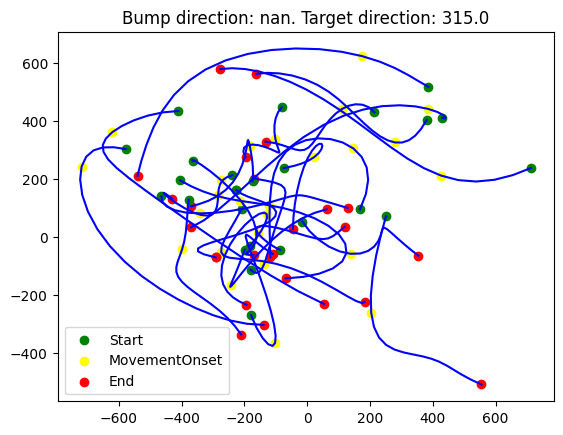

Now showing PC's from MO-prior to MO+post:


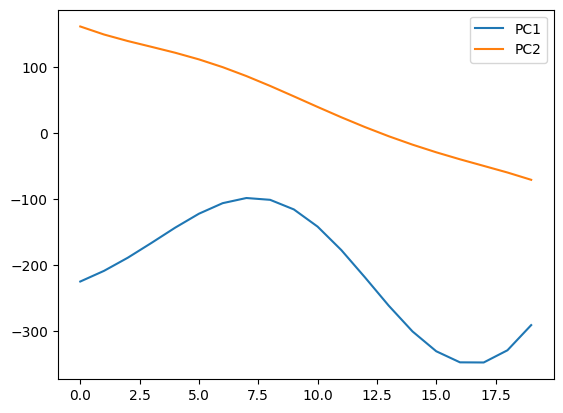

Now showing the averages:


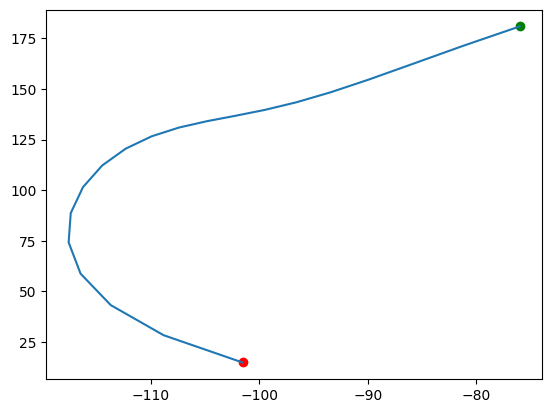

In [32]:
first_index =0
amount = 25
compare_two_pcs(main_df, 1, 2, trialIDS[first_index:first_index + amount], 2, 5, 15)


# PC's during same tgtdir but different bumpdir

I'm interested in observing the behaviour of PC's during trial where the target direction is to one side, while the bump direction is towards another side.

- Plot all PC's per tgtdir
    - What PC's? Per trial or those calculated over all neural data?
        - I think I will plot single PC's seperately, taking all PCA data from trials with specific direction. Multiple lines (tgtdir) per plot (PC).
- Then, choose some tgtdirs and investigate passive / bumpdir vs. active.

In [241]:
def plot_pc_tgtdir(data_df, session, pcs: list = [], tgtdirs: list = [], prior:int=0, post:int=150, title:str = ''):
    
    session_df = data_df[(data_df['session']==session) & (data_df['result'] == 'R')].copy().reset_index(drop=True)
    
    if pcs == []:
        pcs = list(range(30))
    if tgtdirs == []:
        tgtdirs = session_df['tgtDir'].unique().tolist()
    num_rows = int(np.ceil(np.sqrt(len(pcs))))
    num_cols = int(np.ceil(len(pcs) / num_rows))
    
    #Account for prior for which the PCA window ahs been calculated:
    if prior == 0:
        set_prior = session_df.iloc[0]['prior']
    else:
        if prior > session_df.iloc[0]['prior']:
            print(f"Given prior is higher than the prior in the dataset, which is {session_df.iloc[0]['prior']*10}ms currently.")
            return
        set_prior = prior
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    for i, pc in enumerate(pcs):
        col = i // num_cols
        row = i % (num_rows-1)
        for tgtdir in tgtdirs:
            avg_pc = np.mean(session_df[session_df['tgtDir'] == tgtdir]['PCA_window_from_full'], axis=0)
            x = np.linspace((0-set_prior)*10, post*10, avg_pc[set_prior:post, pc].shape[0])
            axs[col, row].plot(x, avg_pc[set_prior:post, pc], label=tgtdir)

            axs[col, row].set_title(f"PC: {pc}")
            axs[col, row].legend()
    if title == '':
        plt.suptitle("Plotting PC's per target direction.")
    else:
        plt.suptitle(f'{title}')
    plt.tight_layout()
    plt.show()

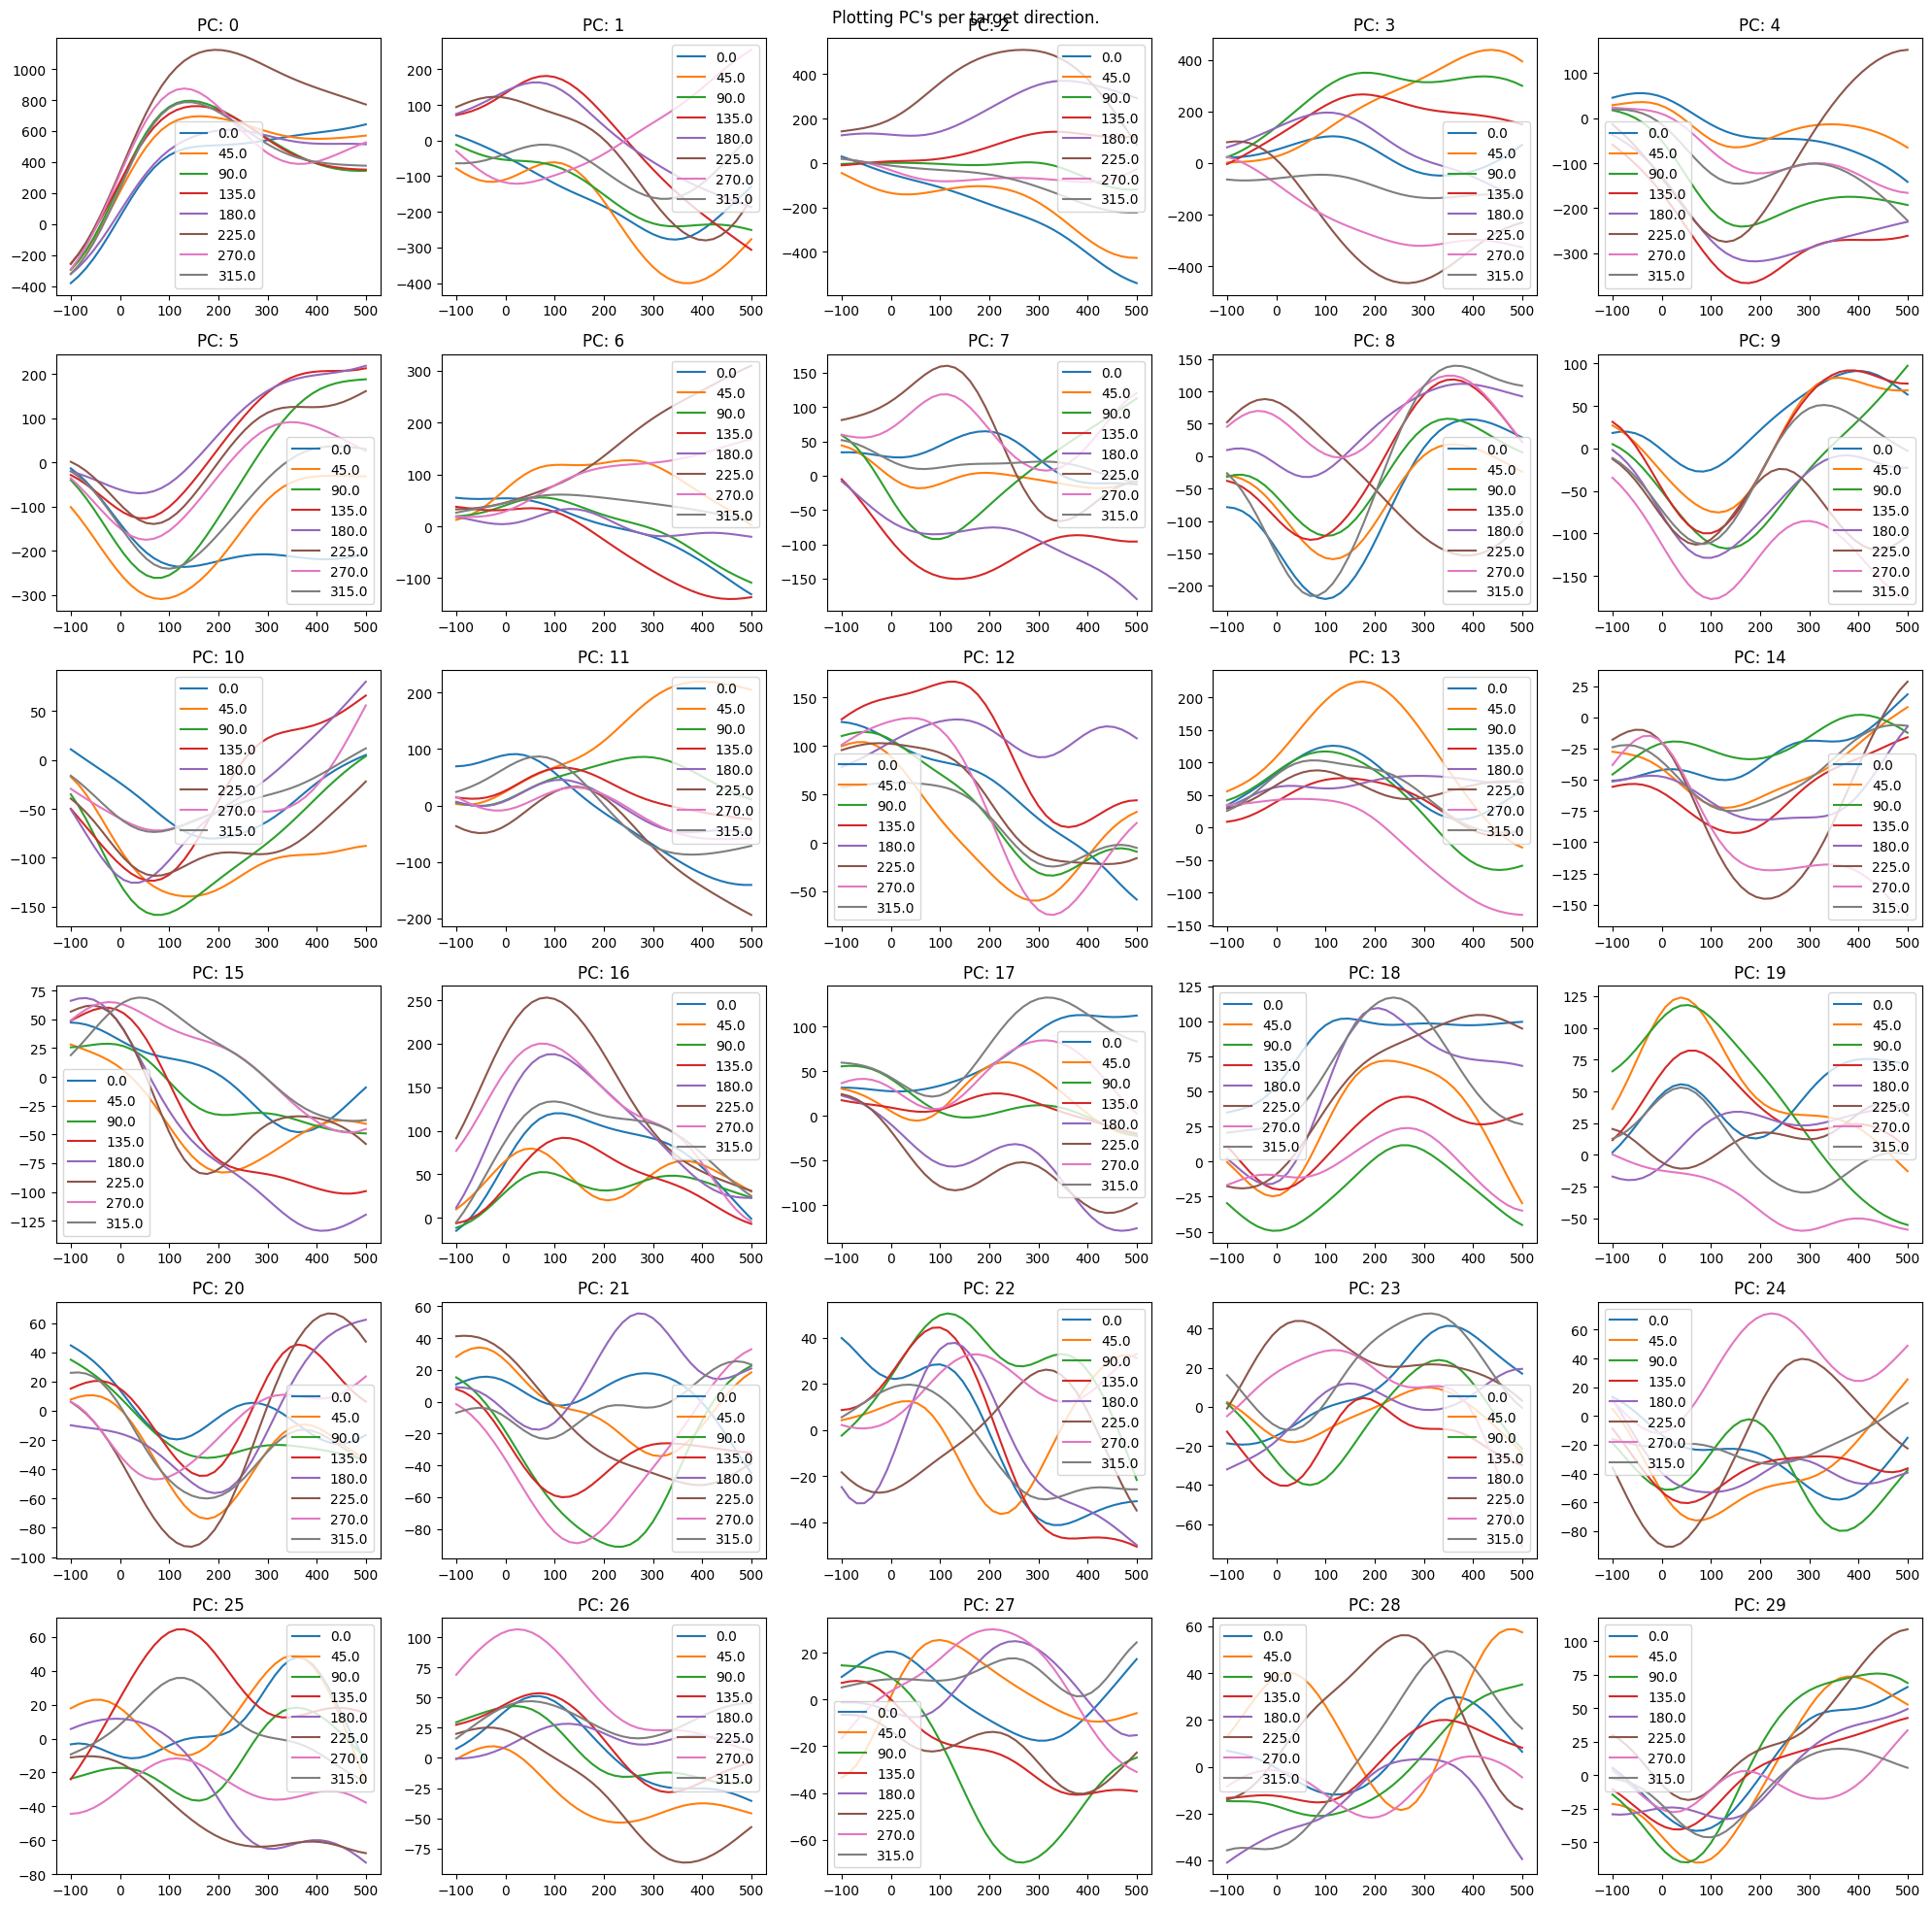

In [242]:
plot_pc_tgtdir(main_df, 2, [], [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0], 10, 50)

# Very interesting!

PC16 for session 2 appears to be encoding some form of movement. It reacts stronger to movements to the south, compared to movements to the north.

437


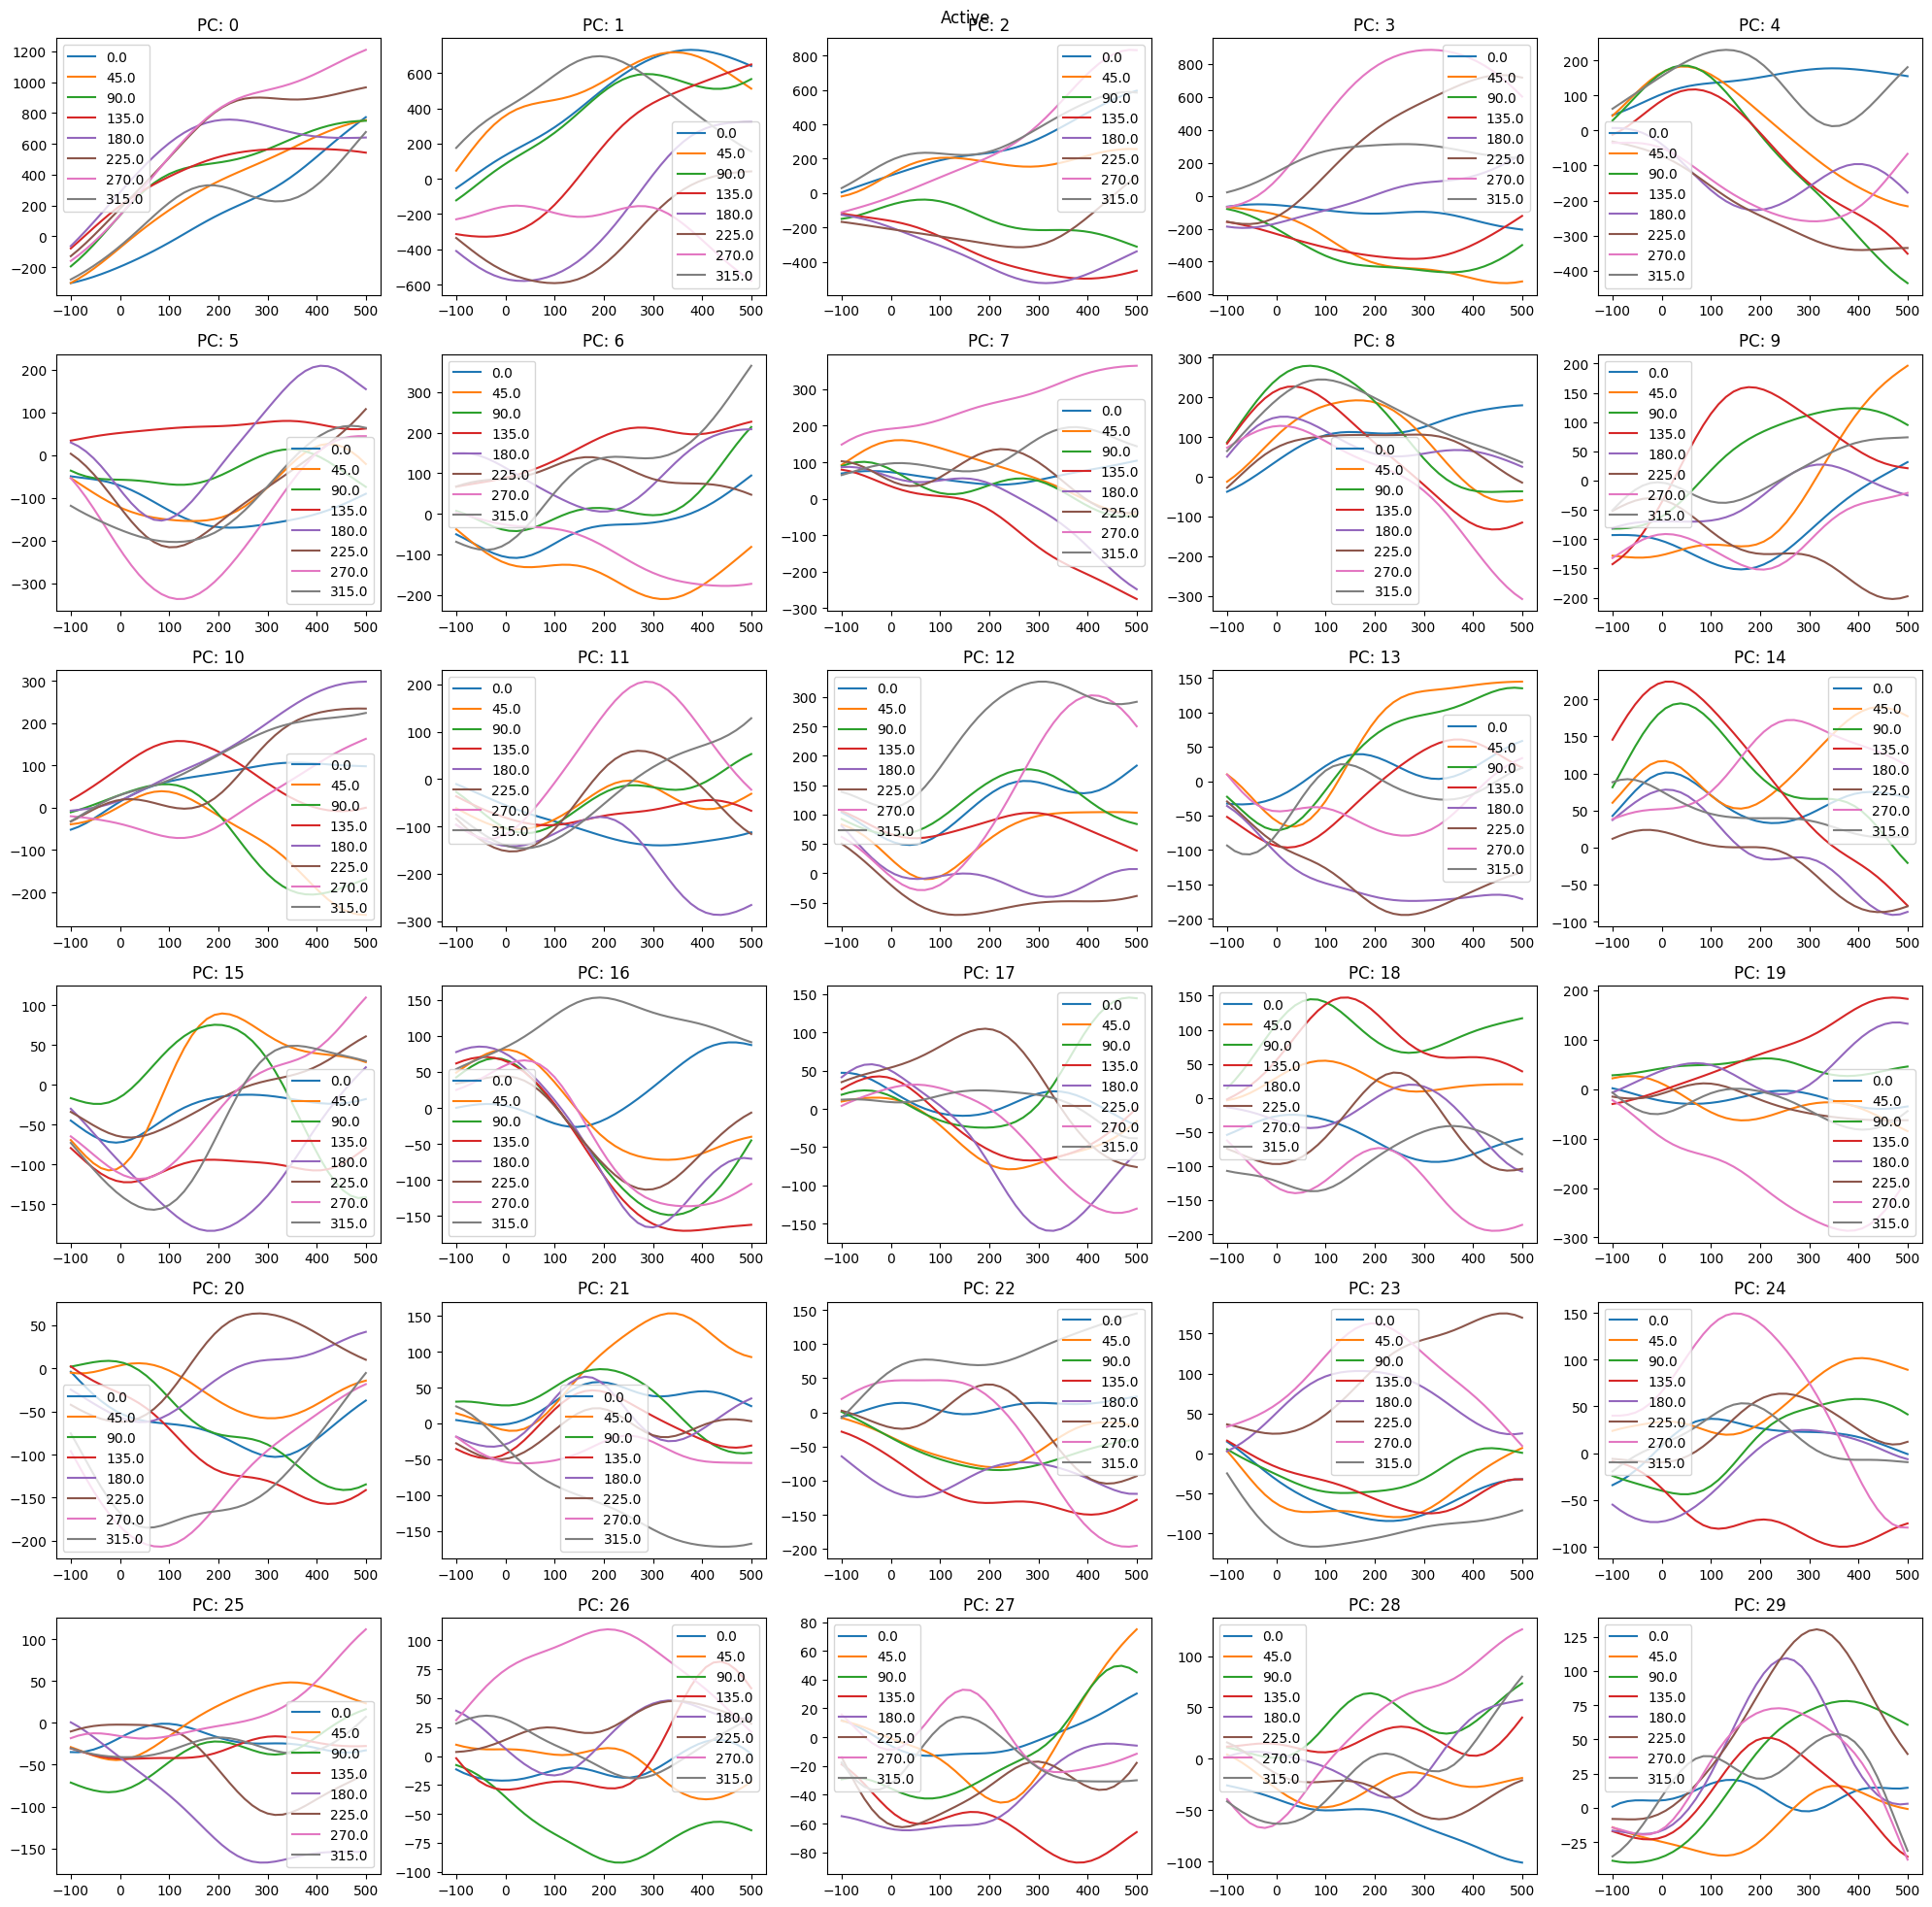

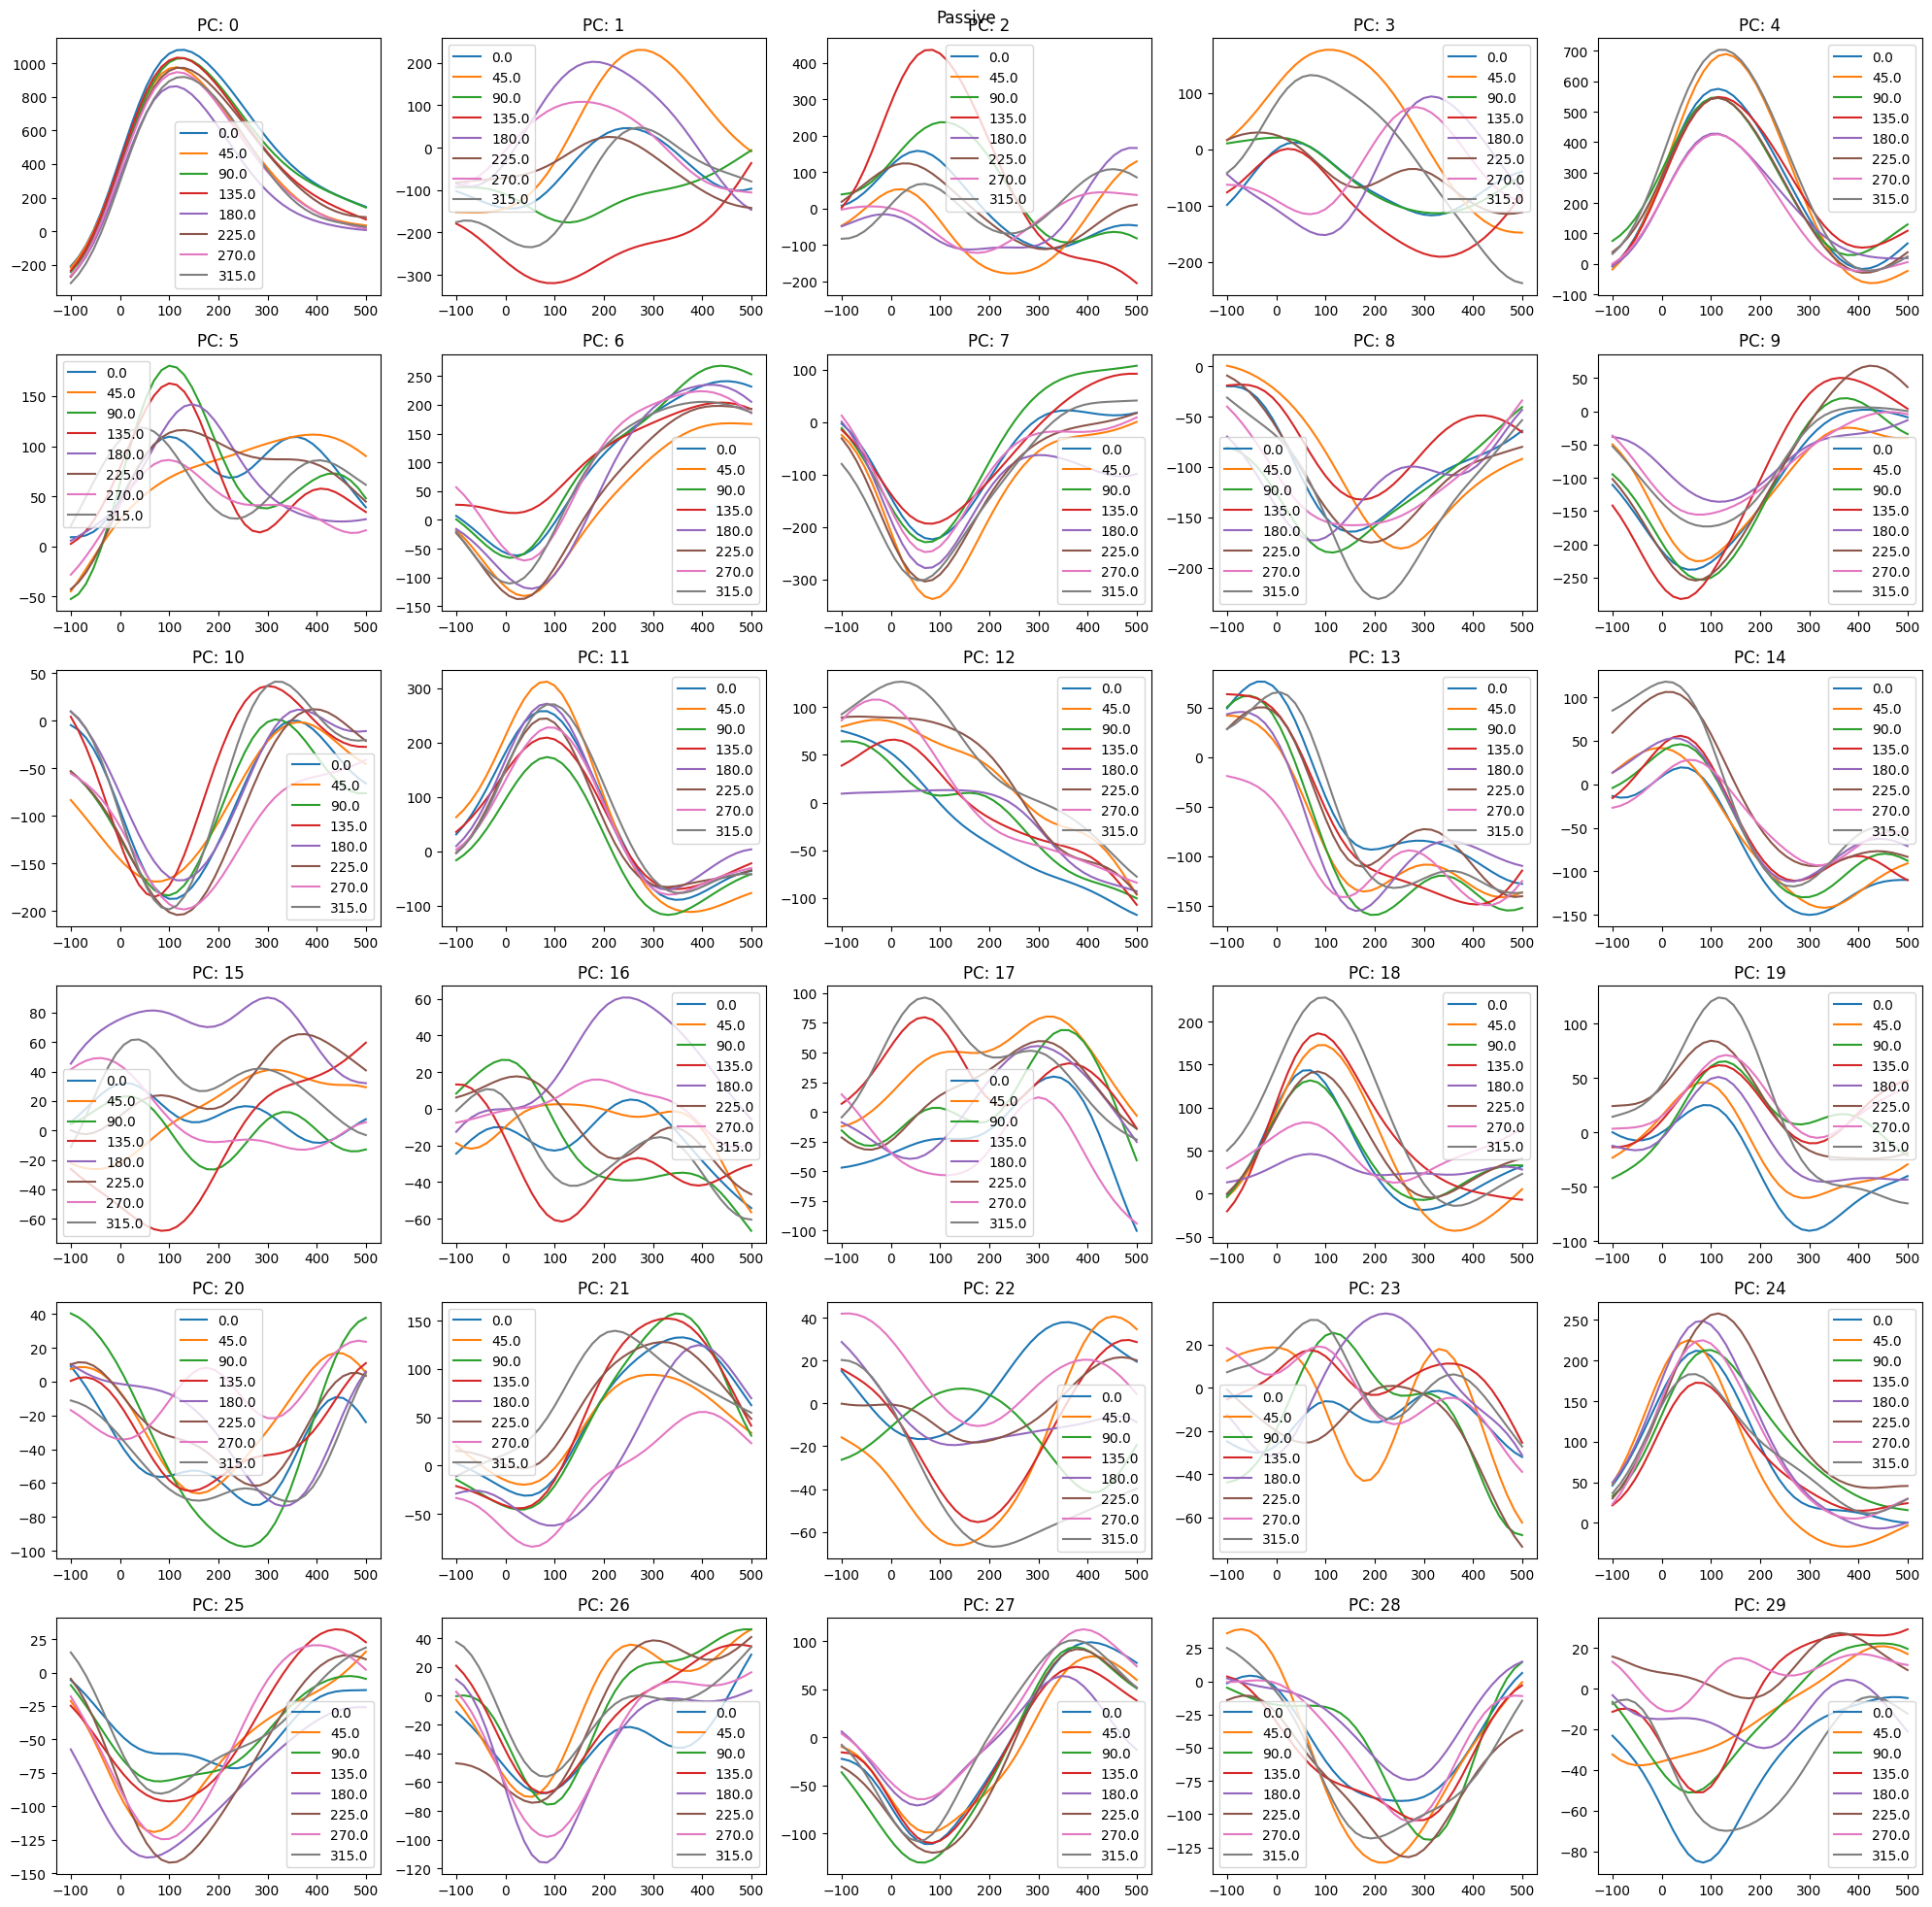

In [243]:
print(len(passive_df))
plot_pc_tgtdir(active_df, 3, [], [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0], 10, 50, "Active")
plot_pc_tgtdir(passive_df, 3, [], [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0], 10, 50, 'Passive')

It's very interesting that, for the passive df, some Pc's have VERY regular trends. See, for example, PC 24 and 27 above. What does this say?

It could be caused by a very low amount of passive trials in this session. Since we have 437 trials, this appears not to be the case.


# Calculate variance per PC

In [210]:
test_df = passive_df[(passive_df['result'] == 'R') & (passive_df['tgtDir'] == 225.0) & (passive_df['session'] == 2)]
col_to_check = test_df['PCA_window_from_full']
print(len(col_to_check))
s2var = np.var(test_df['PCA_window_from_full'].values, axis=0)
print(s2var.shape)

30
(515, 30)


In [211]:
for x in s2var:
    print(x)

[32474.467  40235.547  37350.46   29779.168  17970.06   32044.135
 16486.02   24755.3    29013.639  28947.686  12804.905  11918.168
 20050.291  18706.576  15739.475  16283.775   6490.8135 28143.926
 14909.356  10009.446  15359.447  13636.983  15891.601   5547.166
  7531.731   9427.618   8533.417   6036.126  11879.627   7418.027 ]
[32382.504  41257.2    37518.473  30361.72   18691.168  33378.56
 17007.527  24164.209  27541.023  30262.943  13272.462  12364.3125
 18930.045  19822.885  16405.826  17231.088   6419.4766 27878.121
 15358.316   9629.428  15266.699  13013.973  14570.83    5021.6973
  7785.9077  9551.421   9189.044   6170.4434 12101.266   7714.5625]
[32419.738  42398.984  38013.34   30071.2    19217.537  34978.13
 17576.49   23378.508  26014.768  31144.568  13856.666  13001.298
 17910.615  20811.871  17152.45   17719.307   6338.0044 27191.865
 15711.536   9280.952  14880.841  12468.991  13549.948   4708.284
  8108.3755  9797.645   9890.604   6639.857  12452.137   7969.0093]
[324

# Plotting active vs. passive PC



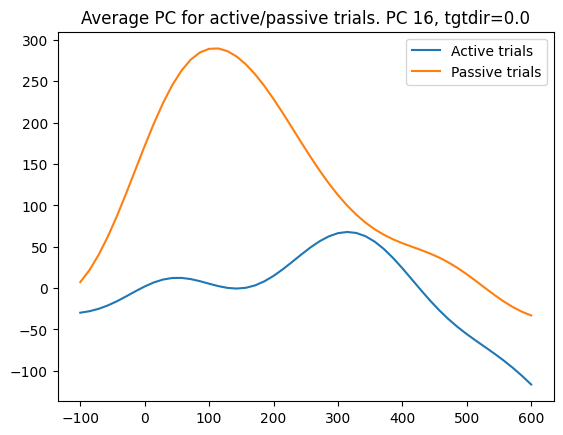

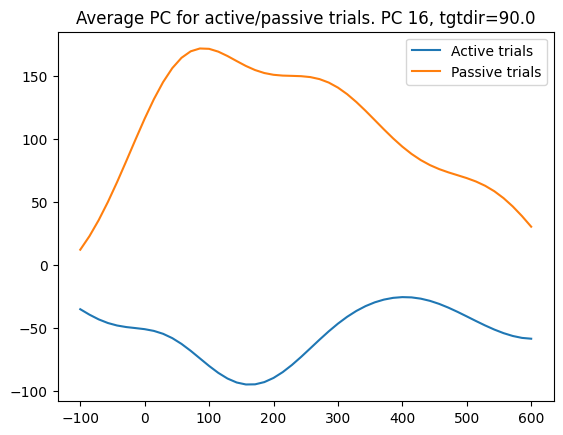

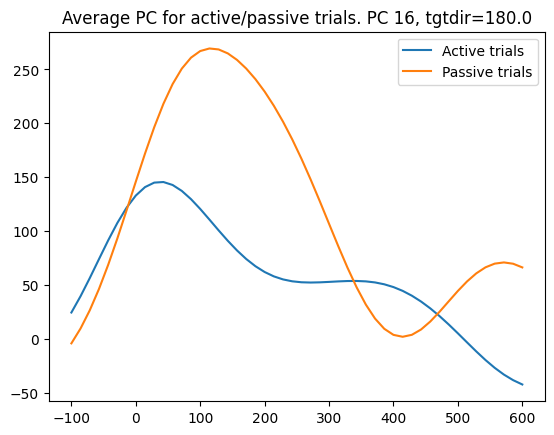

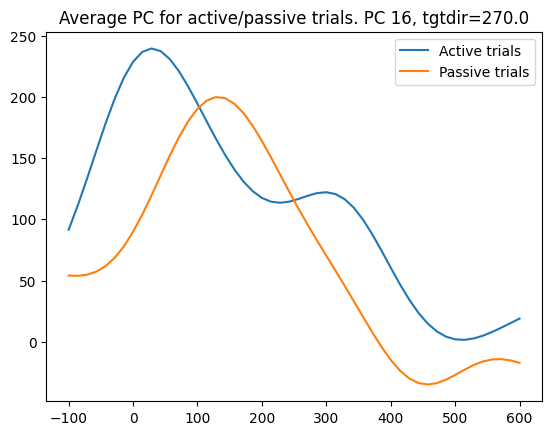

In [255]:
def plot_act_vs_pas(data_df, session, prior, post, pc, tgtdir):
    active_df = data_df[(np.isnan(data_df['bumpDir'])) & (data_df['result'] == 'R') & (data_df['session'] == session) & (data_df['tgtDir'] == tgtdir)].copy().reset_index(drop=True)
    passive_df = data_df[(~np.isnan(data_df['bumpDir'])) & (data_df['result'] == 'R') & (data_df['session'] == session) & (data_df['tgtDir'] == tgtdir)].copy().reset_index(drop=True)
    avg_act = np.mean(active_df['PCA_window_from_full'], axis=0)
    avg_pas = np.mean(passive_df['PCA_window_from_full'], axis=0)
    if prior == 0:
        set_prior = data_df.iloc[0]['prior']
    else:
        assert prior <= data_df.iloc[0]['prior'], f"Note: prior given is too large. Calculated prior in dataset: {data_df.iloc[0]['prior']}"
        set_prior = min(data_df.iloc[0]['prior'], prior)
    post = post+set_prior
    x = np.linspace((0-set_prior)*10, post*10, avg_act[set_prior:post, pc].shape[0])
    plt.plot(x, avg_act[set_prior: post, pc], label=f'Active trials')
    plt.plot(x, avg_pas[set_prior: post, pc], label=f'Passive trials')
    plt.legend()
    plt.title(f"Average PC for active/passive trials. PC {pc}, tgtdir={tgtdir}")
    plt.show()

plot_act_vs_pas(main_df, 2, 10, 50, 16, 0.0)
plot_act_vs_pas(main_df, 2, 10, 50, 16, 90.0)
plot_act_vs_pas(main_df, 2, 10, 50, 16, 180.0)
plot_act_vs_pas(main_df, 2, 10, 50, 16, 270.0)

#for i in range(30):
#    plot_act_vs_pas(main_df, 2, 10, 50, i, 90.0)

# Check whether I can compare tgtdirs per PC comparison

In [314]:
# first_index =0
# amount = 25
# na_315_df = main_df[(pd.isna(main_df['bumpDir'])) & (main_df['session'] == 2) & (main_df['tgtDir'] == 315) & (main_df['result'] == 'R')]
# trialIDS=na_315_df['trialID'].tolist()
# compare_two_pcs(main_df, 1, 16, trialIDS[first_index:first_index + amount], 2, 10, 15)

def compare_pcs(data_df, session, pc1, pc2, prior, post):
    df = data_df[(data_df['session'] == session) & (data_df['result'] == 'R')]
    if prior == 0:
        set_prior = data_df.iloc[0]['prior']
    else:
        assert prior <= data_df.iloc[0]['prior'], f"Note: prior given is too large. Calculated prior in dataset: {data_df.iloc[0]['prior']}"
        set_prior = min(data_df.iloc[0]['prior'], prior)
    

    tgtdirs = df['tgtDir'].unique().tolist()
    radian_tgtdirs = [np.radians(deg) for deg in tgtdirs]
    sorted_radians=sorted(radian_tgtdirs)
    sorted_degrees = [np.degrees(rad) for rad in sorted_radians]
    for tgtdir in sorted_degrees:
        tgt_df = df[df['tgtDir'] == tgtdir]
        avg_pcs = np.mean(tgt_df['PCA_window_from_full'], axis=0)
        plt.plot(avg_pcs[set_prior:(post+set_prior), pc1], avg_pcs[set_prior:(post+set_prior), pc2], label=f"{tgtdir}, #{len(tgt_df)}")
        plt.scatter(avg_pcs[set_prior, pc1], avg_pcs[set_prior, pc2], color='green')
        plt.scatter(avg_pcs[post+set_prior-1, pc1], avg_pcs[post+set_prior-1, pc2], color='red')
    plt.xlabel(f"PC{pc1}")
    plt.ylabel(f"PC{pc2}")
    plt.legend()
    plt.title(f"Averaged PC{pc1} plotted against PC{pc2} by target direction.")
    plt.show()

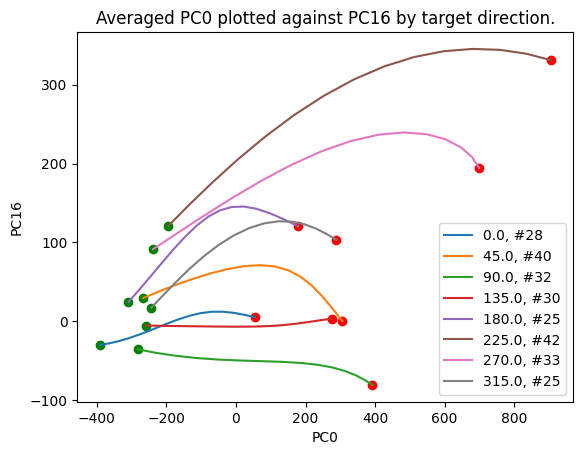

In [315]:
compare_pcs(active_df, 2, 0, 16, 10, 15)

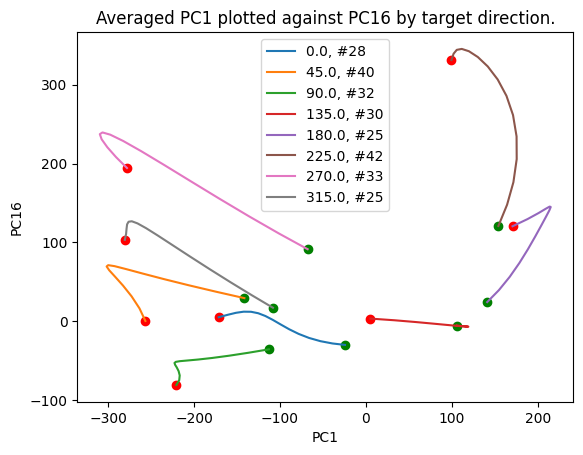

In [316]:
compare_pcs(active_df, 2, 1, 16, 10, 15)

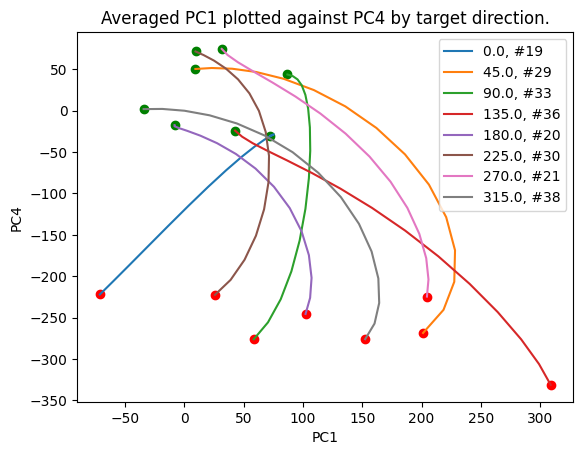

In [318]:
compare_pcs(passive_df, 
            session=2, 
            pc1=1, 
            pc2=4, 
            prior=10, 
            post=15)

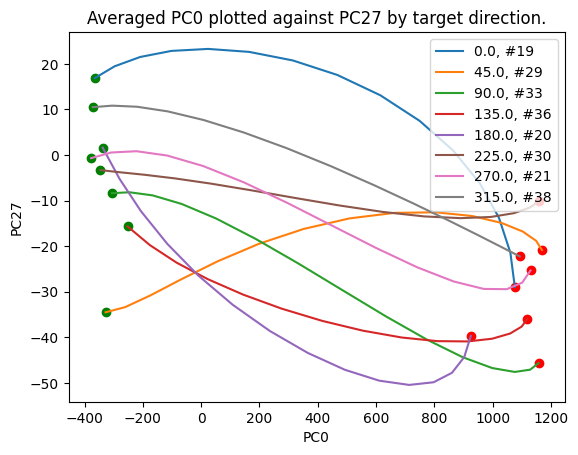

In [322]:
compare_pcs(passive_df, 
            session=2, 
            pc1=0, 
            pc2=27,
            prior=10, 
            post=15)